In [2]:
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    in_colab = False
in_colab

True

In [3]:
if in_colab:
  !pip install neurokit2
  !pip install torchinfo
  !pip install pytorch_lightning
  !pip install wfdb
  !pip install pycwt
  !pip install matplotlib==3.7.0
  #!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

In [4]:
import torch
from torch import optim, nn
from IPython.display import clear_output
from torchinfo import summary
import os
import pywt as pw
from math import ceil
import cv2
from matplotlib import cm
from matplotlib import rcParams
import pytorch_lightning as pl
import imageio
import gc
import collections
from pytorch_lightning.loggers import Logger
from pytorch_lightning.loggers.logger import rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only
import scipy
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import ast
import os
import warnings
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2 as cv

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

warnings.simplefilter(action='ignore', category=FutureWarning)
rcParams['font.weight'] = 'bold'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
if in_colab:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  %cd "drive/MyDrive/Colab Notebooks/ECG_SuperResolution"

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution


In [6]:
if in_colab:
    !ls
else:
    !dir

 activationmap_superresolution_labelCD_ch0-1_noised.png
 activationmap_superresolution_labelCD_nonoise.png
 activationmap_superresolution_labelCD.png
 activationmap_superresolution_labelHYP_ch0-1_noised.png
 activationmap_superresolution_labelHYP_nonoise.png
 activationmap_superresolution_labelHYP.png
 activationmap_superresolution_labelMI_ch0-1_noised.png
 activationmap_superresolution_labelMI_nonoise.png
 activationmap_superresolution_labelMI.png
 activationmap_superresolution_labelNORM_ch0-1_noised.png
 activationmap_superresolution_labelNORM_nonoise.png
 activationmap_superresolution_labelNORM.png
 activationmap_superresolution_labelSTTC_ch0-1_noised.png
 activationmap_superresolution_labelSTTC_nonoise.png
 activationmap_superresolution_labelSTTC.png
 classifier_hr.pt
 classifier_lr.pt
 CNNclassifier.ipynb
 convert_models.ipynb
 data
 ECG-AESR_explainability.ipynb
 ECG-AESR_MultiMode_Wavelets+ECG.ipynb
 ECG-AESR_predictSRQuality.ipynb
 ECG_AESR_robustness_channelmissing.ipynb
 ECG-

In [7]:
from functions import *

In [8]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

In [9]:
!python --version

Python 3.10.12


In [10]:
torch.__version__

'2.3.0+cu121'

In [11]:
torch.cuda.is_available()

True

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
%matplotlib inline

In [14]:
torch.set_float32_matmul_precision("medium")

In [15]:
labels = list(map_superclass_rev.keys())


In [16]:
fs_lr = 50
fs_hr = 500

In [17]:
del map_superclass_rev["All"]
labels = map_superclass_rev.keys()
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_test_lr_n = {}
path = os.getcwd()+os.sep+"pt_data"+os.sep

for label in labels:

    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data

dict_windows_test = dict_windows_test_lr

In [18]:
def torch_argwhere_in_list(tensor, list):

    idxs = []
    tensor.flatten()
    for i, elem in enumerate(tensor):
        elem = elem.item()
        for j in list:
            if elem == j:
                idxs.append(i)
    return idxs

In [19]:
import os
cwd = os.getcwd()
sep = os.sep
cwd

'/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution'

In [20]:
modelspath = cwd + sep + "models"
modelpath = modelspath + sep + "model_2_denoising_lrhr_v2.pt"
model1d = torch.load(modelpath).to(device)
model1d

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1446: UserWarning: This figure was saved with matplotlib version 3.7.1 and is unlikely to function correctly.
  result = unpickler.load()


VAE1d_SR_multimodal(
  (encoder): Encoder1d(
    (encoder): Sequential(
      (0): EncoderBlock1d(
        (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderBlock1d(
        (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=False)
        (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder1d(
    (decoder): Sequential(
      (0): DecoderBlock1d(
        (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.1, inplace=

In [21]:
def plot_super_resolution_explainability(data_hr, data_sr, channel = None):

    n = data_hr.shape[-1]
    t = np.arange(0, n, 1)

    if channel is None:
        fig, axs = plt.subplots(12, 1, figsize = (20, 20))
        nchs = 12
    else:
        fig, axs = plt.subplots(1, 1, figsize = (20, 5))
        nchs = 1

    sig_or = data_hr
    sig_recons = data_sr

    loss = F.mse_loss(sig_or, sig_recons).item()#device
    fig.suptitle("MSE Loss: {}".format(loss))


    #print(sig_or.shape, sig_recons.shape)
    sig_recons = sig_recons.cpu().detach().numpy()
    sig_or = sig_or.cpu().detach().numpy()

    if channel is None:

        fig.subplots_adjust(wspace=0, hspace=1)
        #fig.tight_layout(pad=0.000)
        for j in range(nchs):

            y_min = min([min(sig_or[0, j, :]), min(sig_recons[0, j, :])])
            y_max = max([max(sig_or[0, j, :]), max(sig_recons[0, j, :])])

            for line in axs[j].get_lines(): # ax.lines:
                line.remove()
            if j == 0:
                axs[j].plot(t, sig_or[0, j, :], "g", label = "GT high resolution 500Hz")
                axs[j].plot(t, sig_recons[0, j, :], "b", label =  "reconstructed super resolution 500Hz")
            else:
                axs[j].plot(t, sig_or[0, j, :], "g")
                axs[j].plot(t, sig_recons[0, j, :], "b")
            axs[j].title.set_text("Channel {}".format(j+1))
            axs[j].set_ylim([y_min, y_max])
    else:

        y_min = min([min(sig_or[0, 0, :]), min(sig_recons[0, 0, :])])
        y_max = max([max(sig_or[0, 0, :]), max(sig_recons[0, 0, :])])

        for line in axs.get_lines(): # ax.lines:
            line.remove()
        axs.plot(t, sig_or[0, 0, :], "g", label = "GT high resolution 500Hz")
        axs.plot(t, sig_recons[0, 0, :], "b", label =  "reconstructed super resolution 500Hz")
        axs.title.set_text("Channel {}".format(channel))
        axs.set_ylim([y_min, y_max])

    fig.legend()

471


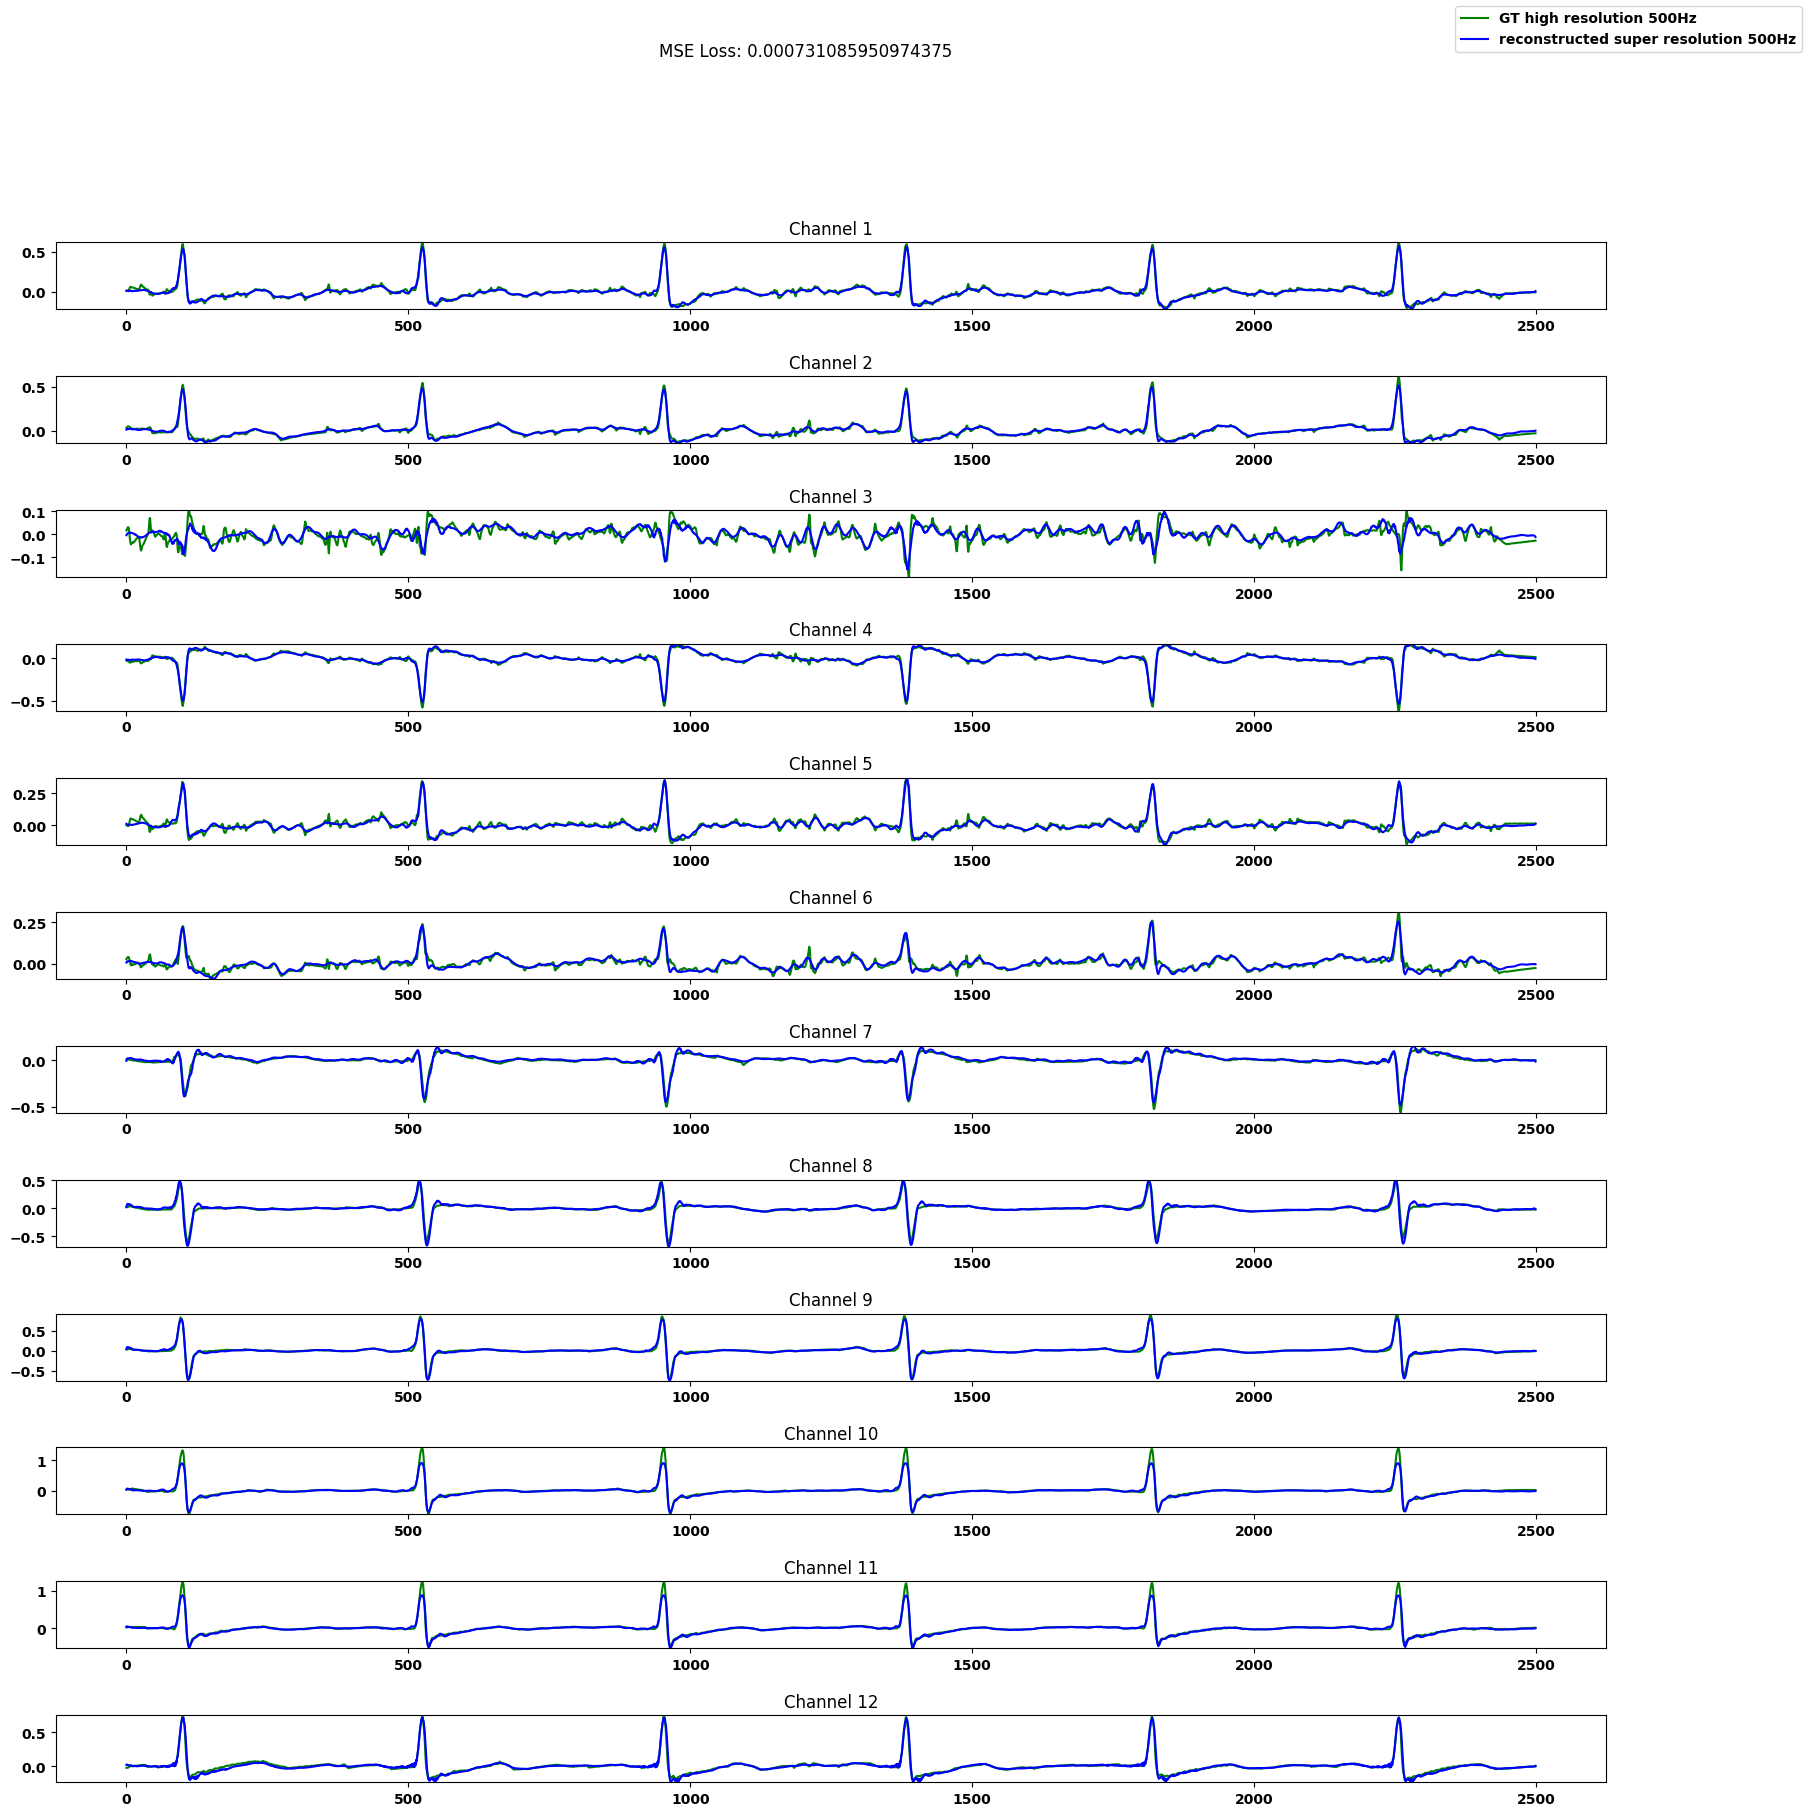

In [ ]:
%matplotlib inline
from random import choice
model1d.eval()

n = len(dict_windows_test[label])
nchs = 12
idx = choice(np.arange(n))
print(idx)

loss_name = "mse"
loss_f = get_loss_function(loss_name)

lr_data = dict_windows_test[label][idx]#.cpu()
hr_data = dict_windows_test_hr[label][idx]#.cpu()

ch = "All Channels"
if ch != "All Channels":
    lr_data = lr_data[:, ch, :]
    hr_data = hr_data[:, ch, :]

data = [lr_data, None, None, None]
pred = model1d(data)

sr_data = pred[1]
sr_data = torch.unsqueeze(sr_data, dim = 0)

loss = loss_f(hr_data, sr_data)

if ch == "All Channels":
  channel = None
  plot_super_resolution_explainability(hr_data, sr_data, channel = channel)
else:
  plot_super_resolution_explainability(hr_data, sr_data, channel = channels_map[ch])

In [ ]:
x_test = [x.cpu().detach().numpy() for x in dict_windows_test_lr_n[label]]
x_test_hr = [x.cpu().detach().numpy() for x in dict_windows_test_hr[label]]
x_test = np.array(x_test)
x_test_hr = np.array(x_test_hr)
x_test = x_test[:, 0, :, :]
x_test_hr = x_test_hr[:, 0, :, :]
x_test.shape, x_test_hr.shape

((1088, 12, 250), (1088, 12, 2500))

In [ ]:
lr_data = x_test[0]
hr_data = x_test_hr[0]
lr_data.shape, hr_data.shape

((12, 250), (12, 2500))

In [ ]:
lr_data_t = torch.from_numpy(lr_data).to(device)
lr_data_t = torch.unsqueeze(lr_data_t, dim = 0)
model1d([lr_data_t, None])

[tensor([[ 0.0788,  0.0477,  0.0499,  ..., -0.0417, -0.0544, -0.0365],
         [ 0.0652,  0.0451,  0.0457,  ..., -0.0600, -0.0580, -0.0386],
         [ 0.0711,  0.0666,  0.0628,  ..., -0.0545, -0.0298, -0.0191],
         ...,
         [ 0.0594,  0.0314,  0.0517,  ...,  0.0406,  0.0286,  0.0130],
         [ 0.0713,  0.0193,  0.0368,  ..., -0.0882, -0.0747, -0.0239],
         [ 0.0634,  0.0280,  0.0304,  ..., -0.1040, -0.0889, -0.0502]],
        device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor([[-0.0179, -0.0200, -0.0091,  ..., -0.0145, -0.0184, -0.0232],
         [-0.0020, -0.0075, -0.0195,  ..., -0.0010, -0.0009,  0.0103],
         [-0.0107, -0.0036,  0.0007,  ...,  0.0194,  0.0177,  0.0099],
         ...,
         [-0.0194, -0.0409, -0.0402,  ...,  0.0443,  0.0483,  0.0498],
         [ 0.0067, -0.0213, -0.0481,  ..., -0.0103, -0.0017,  0.0187],
         [-0.0240, -0.0340, -0.0292,  ..., -0.0235, -0.0162, -0.0177]],
        device='cuda:0', grad_fn=<SqueezeBackward1>),
 [tensor([

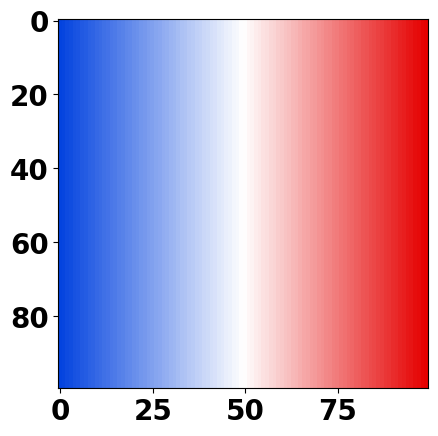

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

colors = ["xkcd:Blue", "White", "xkcd:Red"]
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=150)
mat = np.indices((100,100))[1]
plt.imshow(mat, cmap=cm)
plt.show()

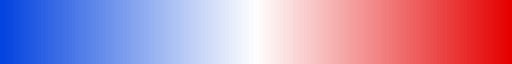

In [36]:
cm

In [ ]:
lr_data.shape, hr_data.shape

((12, 250), (12, 2500))

In [23]:
from scipy import interpolate

def interpolate_sr(signals, fs_lr=50, fs_hr = 500, nchs=12, mode = 'cubic'):
    # Interpolation to 500 Hz
    t_low_res = np.arange(0, 5, 1/fs_lr)
    t_high_res = np.arange(0, 5, 1/fs_hr)  # 500 Hz sampling rate
    signals_sr = []
    for signal in signals:

        f_interp = interpolate.interp1d(t_low_res, signal, kind=mode, fill_value="extrapolate")
        signal_sr = f_interp(t_high_res)
        if isinstance(signal_sr, (np.ndarray, np.generic) ):
            signal_sr = torch.from_numpy(signal_sr)
        signals_sr.append(signal_sr)
    signals_sr = torch.stack(signals_sr)
    return signals_sr

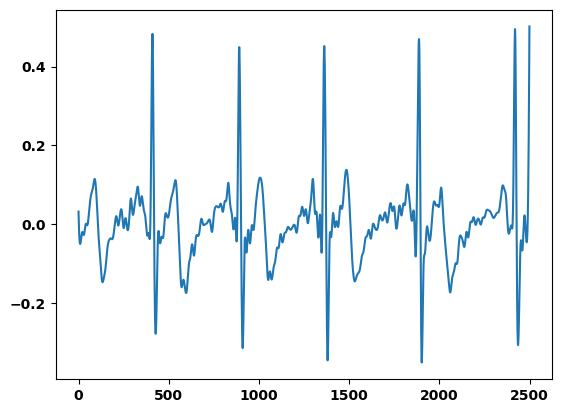

In [ ]:
ch = 0
data_int = interpolate_sr([lr_data])
data_int = torch.squeeze(data_int, dim = 0)
plt.plot(data_int[ch, :])

In [ ]:
lr_data.shape

(12, 250)

In [ ]:
data_int = interpolate_sr([lr_data])
data_int = torch.squeeze(data_int, dim = 0).cpu().detach().numpy()

In [ ]:
x_test = dict_windows_test_lr_n[label]
x_test_hr = dict_windows_test_hr[label]

In [24]:
from scipy import interpolate
from matplotlib import colors

def interpolate_sr(signals, fs_lr=50, fs_hr = 500, nchs=12, mode = 'cubic'):
    # Interpolation to 500 Hz
    t_low_res = np.arange(0, 5, 1/fs_lr)
    t_high_res = np.arange(0, 5, 1/fs_hr)  # 500 Hz sampling rate
    signals_sr = []
    for signal in signals:
        f_interp = interpolate.interp1d(t_low_res, signal, kind=mode, fill_value="extrapolate")
        signal_sr = f_interp(t_high_res)
        if isinstance(signal_sr, (np.ndarray, np.generic) ):
            signal_sr = torch.from_numpy(signal_sr)
        signals_sr.append(signal_sr)
    signals_sr = torch.stack(signals_sr)
    return signals_sr

In [ ]:
losses = []
sr_windows = []

loss_f = get_loss_function("mse")

for i, lr_data in enumerate(x_test):

  pred = model1d([lr_data, None])
  sr_data = pred[1]
  hr_data = x_test_hr[i]
  loss = loss_f(hr_data, sr_data)
  losses.append(loss.item())
  sr_windows.append(sr_data)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 2500])) that is different to the input size (torch.Size([1, 12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
lr_data.shape

torch.Size([1, 12, 250])

In [ ]:
idxs = np.argsort(losses)[::-1]
i = 50
loss = losses[idxs[i]]
sr_data = sr_windows[idxs[i]]
hr_data = x_test_hr[idxs[i]]
lr_data = x_test[idxs[i]]
lr_int = interpolate_sr(lr_data.cpu())
lr_int = torch.squeeze(lr_int, dim = 0)

In [ ]:
diff = []
nchs = 12
width = 2500

for ch, hr_datach in enumerate(hr_data):
  temp = []
  for i, elem_hr in enumerate(hr_datach):
    elem_sr = sr_data[ch, i]
    temp.append(elem_hr - elem_sr)
  temp = torch.stack(temp)
  diff.append(temp)
diff = torch.stack(diff)
diff = diff[0].cpu().detach().numpy()
diff.shape

(12, 2500)

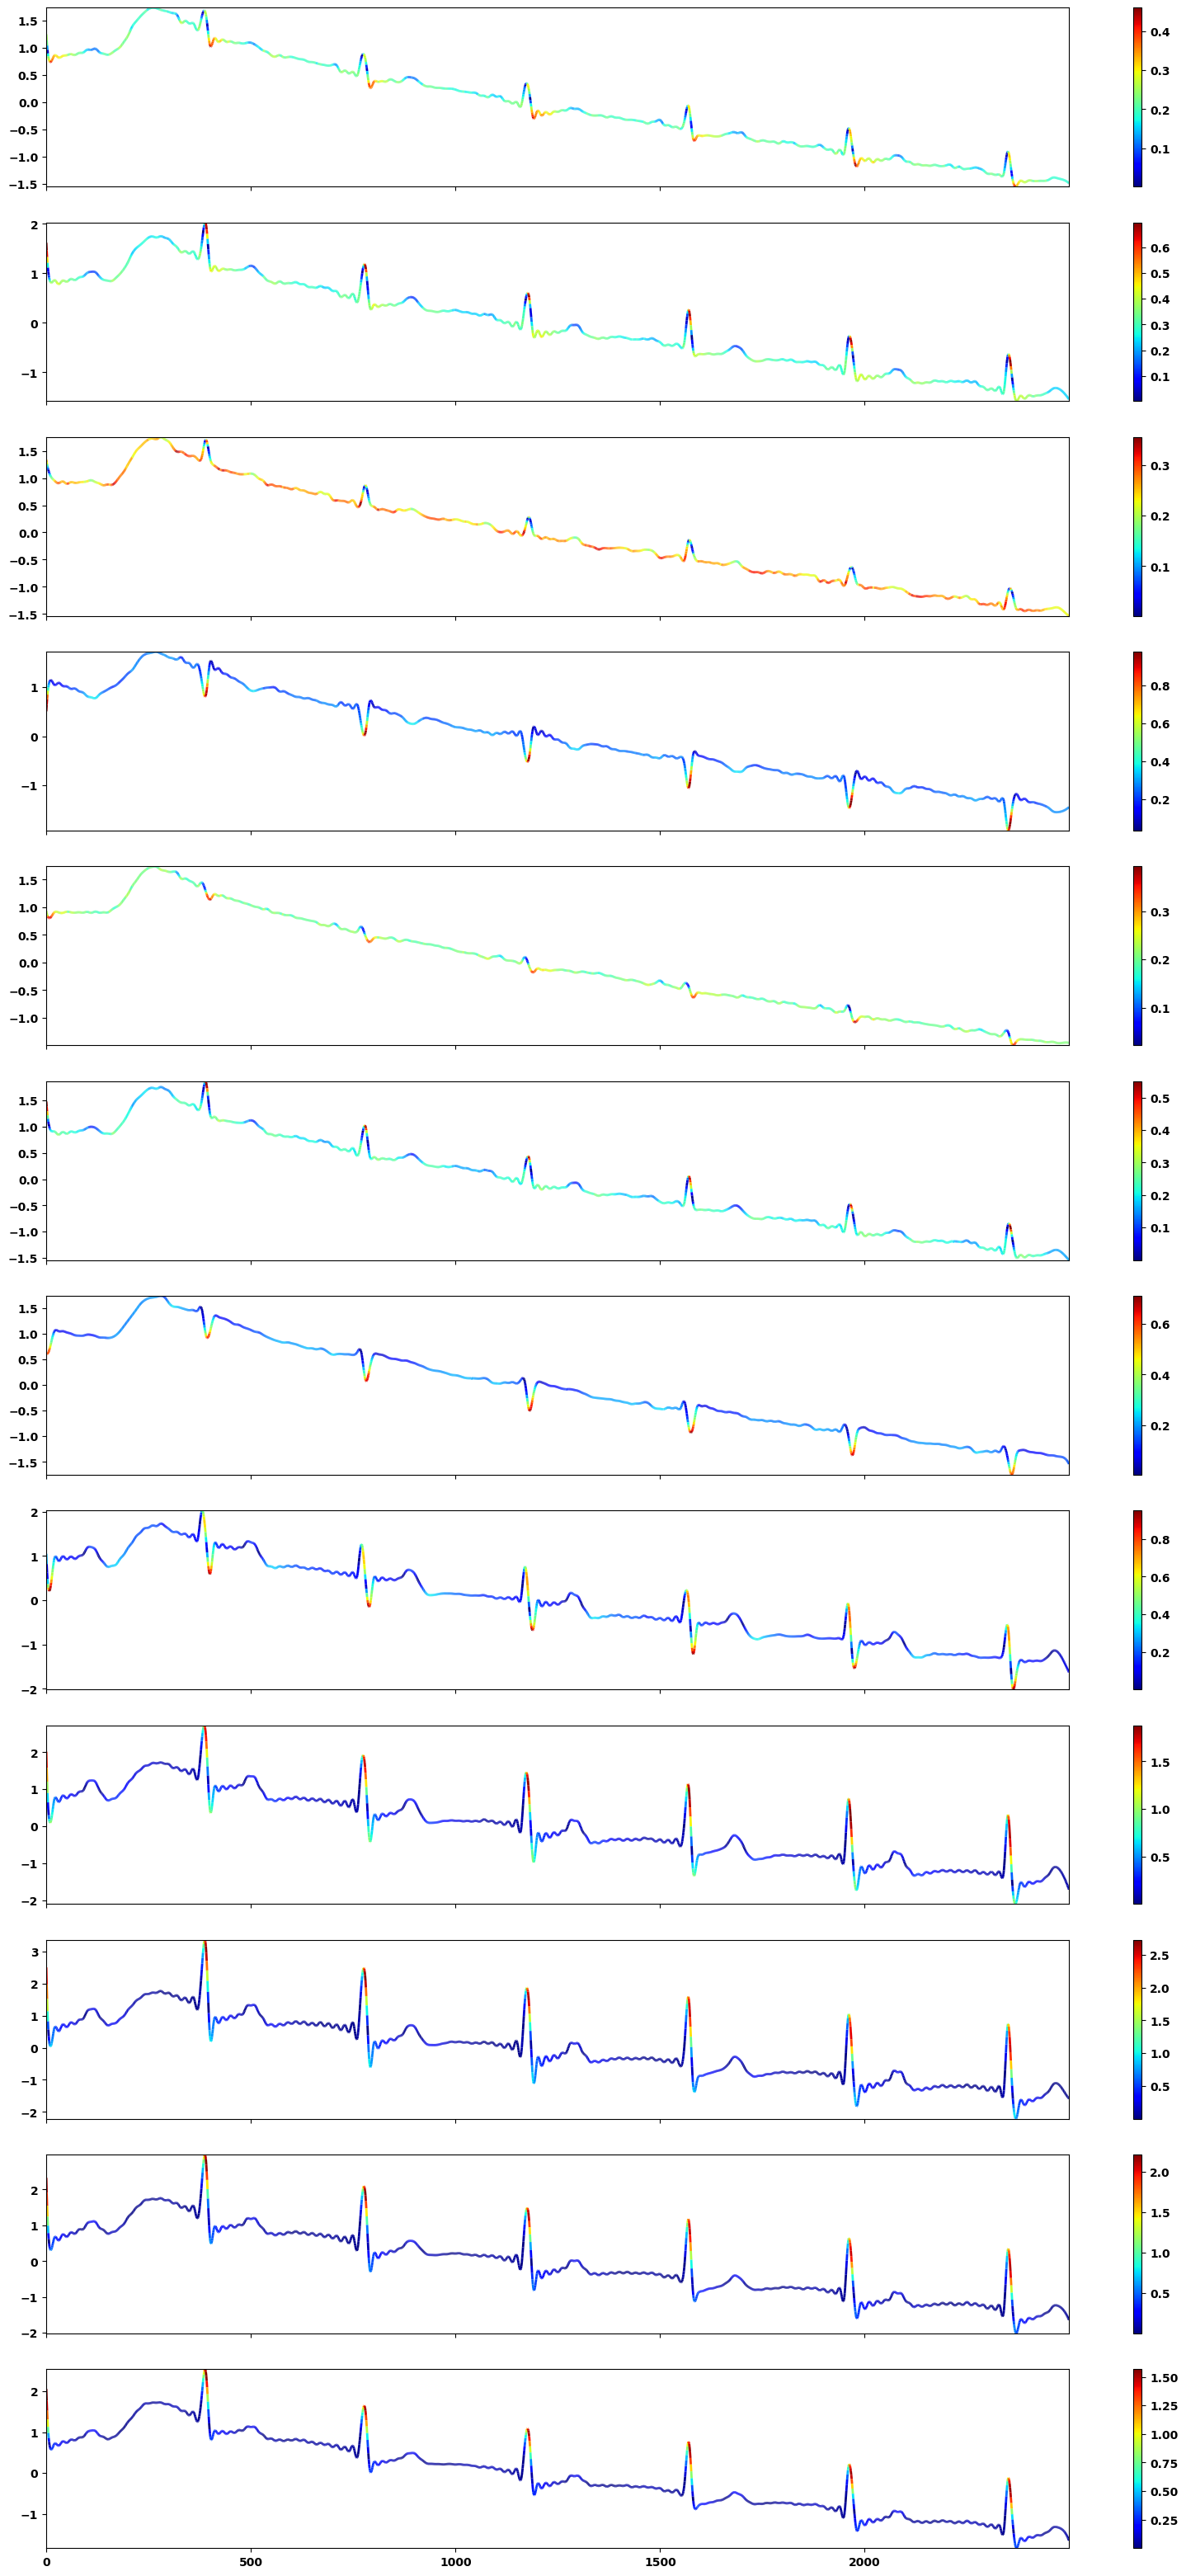

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

nchs = 12
fig, axs = plt.subplots(nchs, 1, sharex=True, sharey=False, figsize = (20, 40))
x = np.arange(0, 2500, 1)

for ch in range(nchs):

  y = lr_int[ch, :]
  #print(x.shape, y.shape, shap_values[ch, :].shape)

  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  #print(points.shape, segments.shape)

  # Create a continuous norm to map from data points to colors
  diff = np.abs(diff)
  norm = plt.Normalize(diff[ch, :].min(), diff[ch, :].max())
  lc = LineCollection(segments, cmap=cm, norm=norm)

  # Set the values used for colormapping
  lc.set_array(diff[ch, :])
  lc.set_linewidth(2)
  if nchs == 1:
    ax = axs
  else:
    ax = axs[ch]

  line = ax.add_collection(lc)
  fig.colorbar(line, ax=ax)
  ax.set_xlim(x.min(), x.max())
  ax.set_ylim(y.min(), y.max())

  #ax.plot(hr_data[0, ch, :].cpu().detach().numpy(), "--g", alpha = 0.5, label = "hr")
  #ax.plot(sr_data[ch, :].cpu().detach().numpy(), "--r", alpha = 0.5, label = "sr")
  #ax.legend(loc = "lower left")
plt.show()

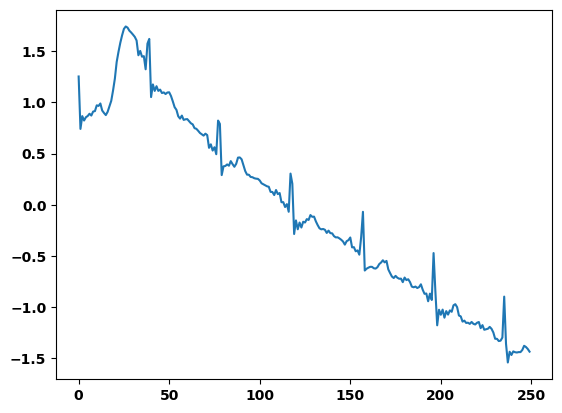

In [ ]:
plt.plot(lr_data[0, 0,  :].cpu().detach().numpy())

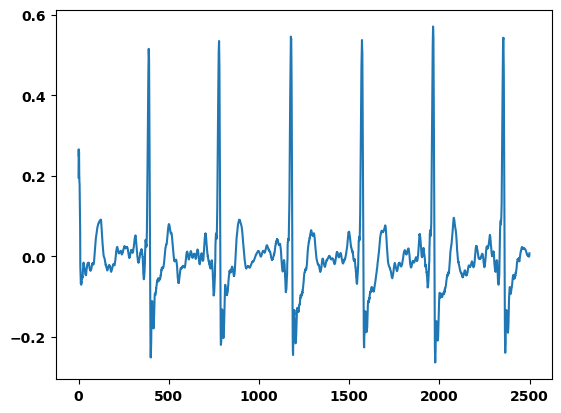

In [ ]:
plt.plot(sr_data[0,  :].cpu().detach().numpy())

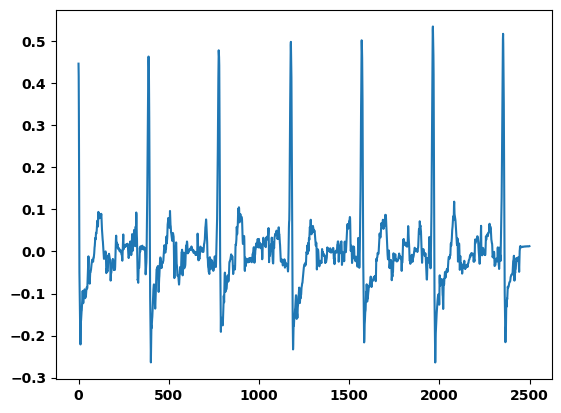

In [ ]:
plt.plot(hr_data[0, 0,  :].cpu().detach().numpy())

In [ ]:
diff = []
nchs = 12
width = 2500

for ch, lr_datach in enumerate(lr_data):
  temp = []
  for i, elem_lr in enumerate(lr_datach):
    elem_sr = sr_data[ch, i]
    temp.append(elem_lr - elem_sr)
  temp = torch.stack(temp)
  diff.append(temp)
diff = torch.stack(diff)
diff = diff[0].cpu().detach().numpy()
diff.shape

(12, 250)

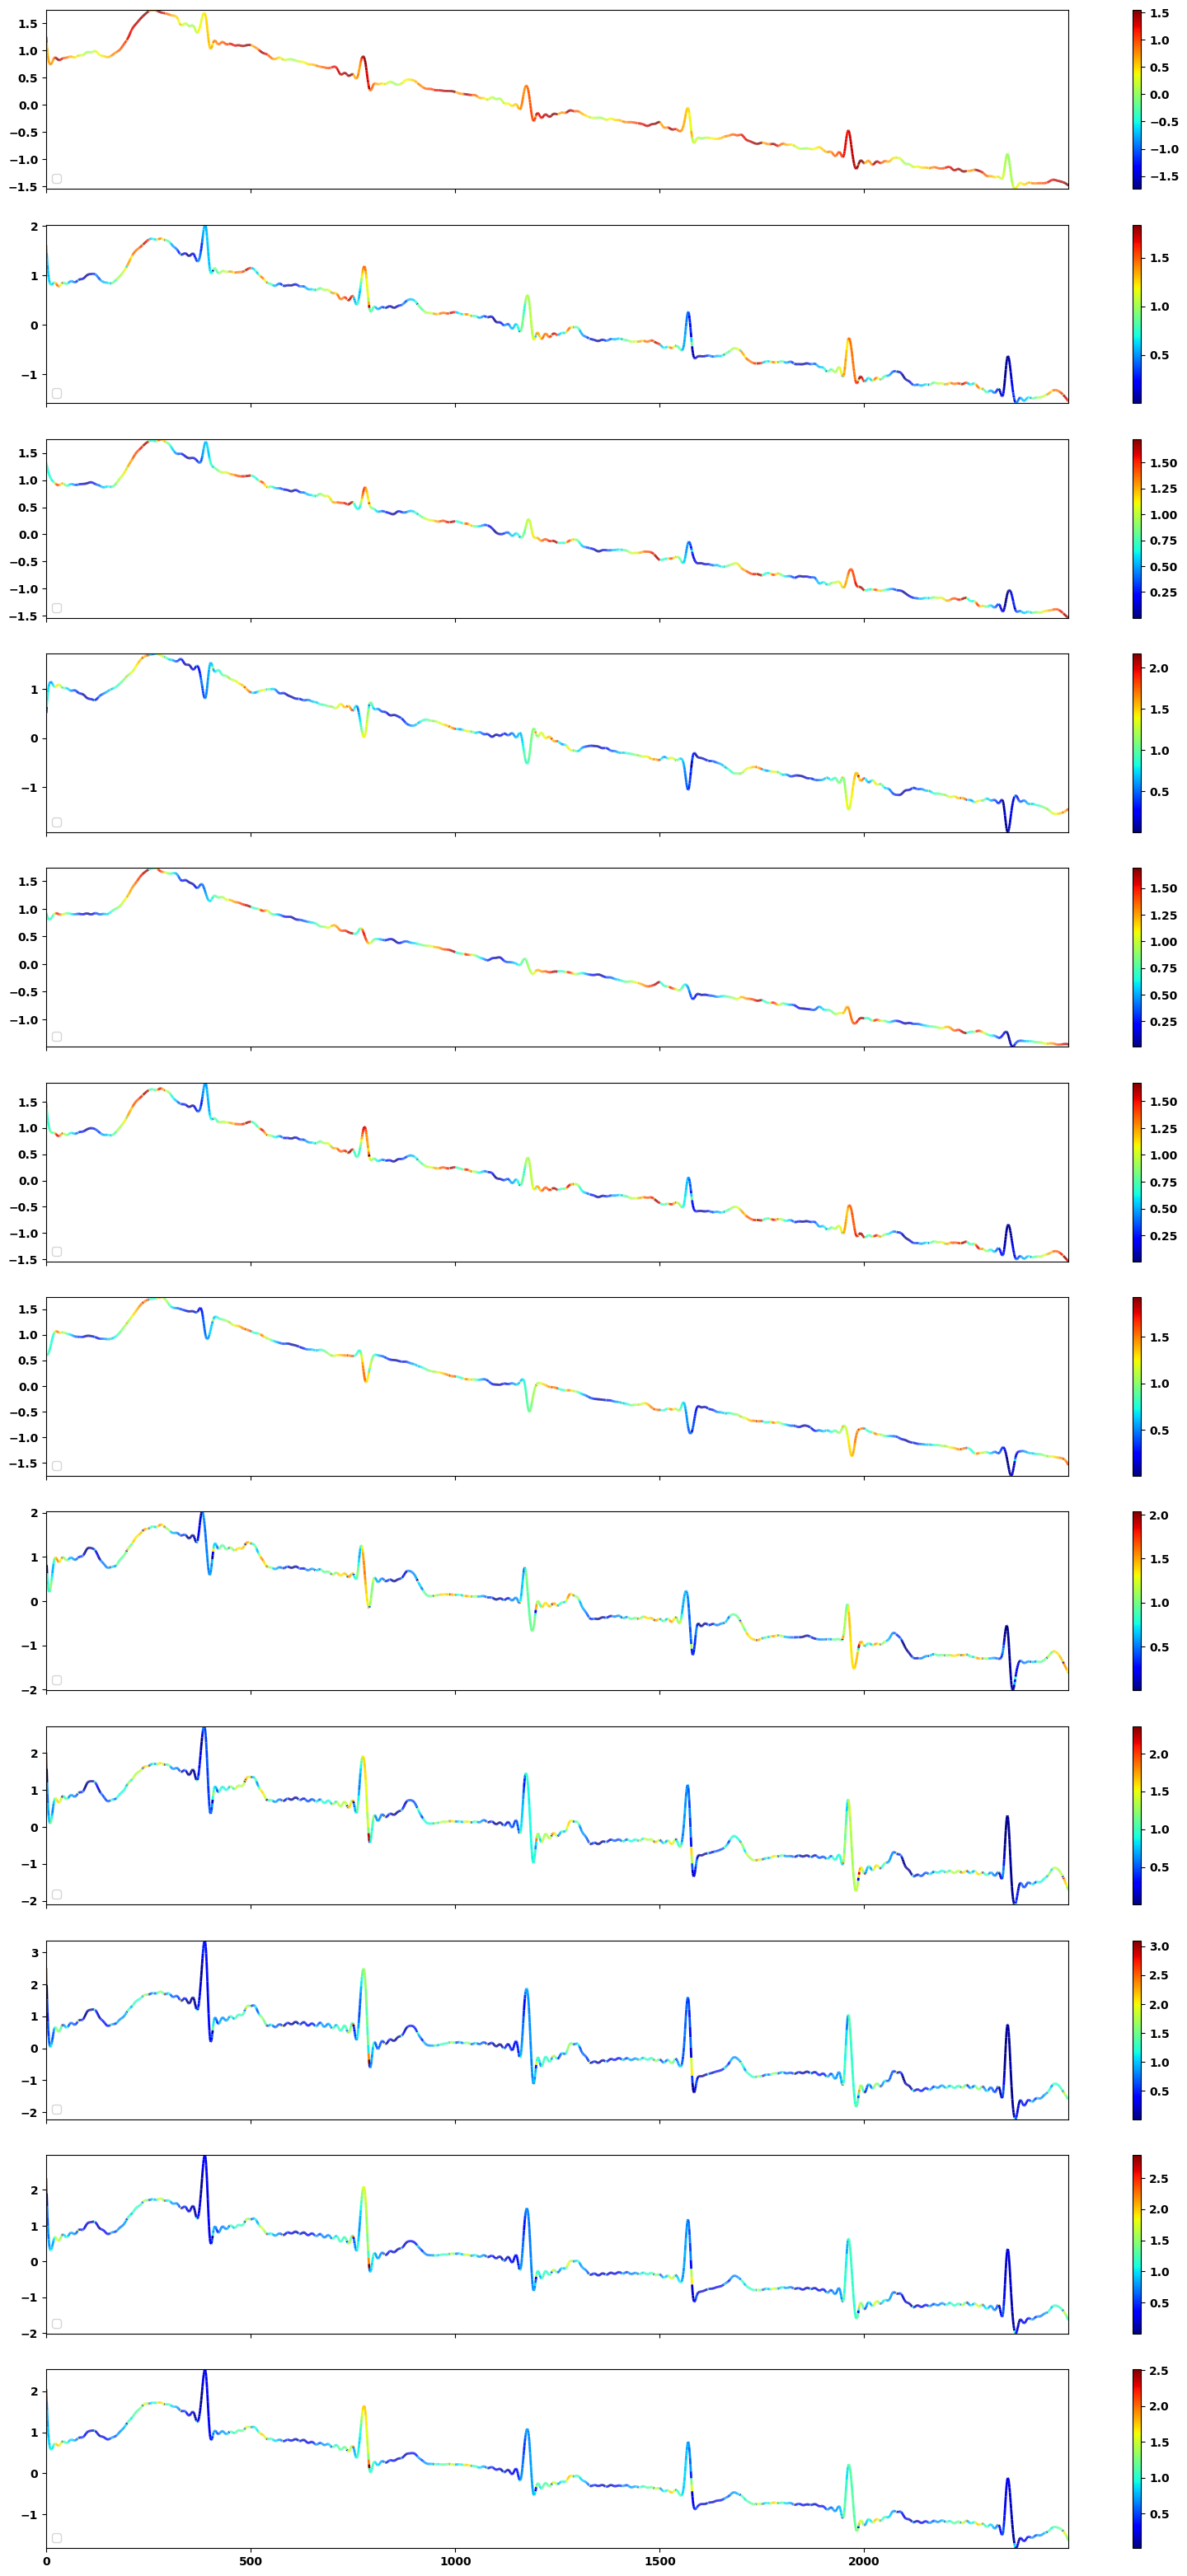

In [ ]:
nchs = 12
fig, axs = plt.subplots(nchs, 1, sharex=True, sharey=False, figsize = (20, 40))
x = np.arange(0, 2500, 1)

for ch in range(nchs):

  y = lr_int[ch, :]
  #print(x.shape, y.shape, shap_values[ch, :].shape)

  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  #print(points.shape, segments.shape)

  # Create a continuous norm to map from data points to colors
  norm = plt.Normalize(diff[ch, :].min(), diff[ch, :].max())
  lc = LineCollection(segments, cmap=cm, norm=norm)

  diff = np.abs(diff)
  # Set the values used for colormapping
  lc.set_array(diff[ch, :])
  lc.set_linewidth(2)
  if nchs == 1:
    ax = axs
  else:
    ax = axs[ch]

  line = ax.add_collection(lc)
  fig.colorbar(line, ax=ax)
  ax.set_xlim(x.min(), x.max())
  ax.set_ylim(y.min(), y.max())

  #ax.plot(lr_int[0, ch, :].cpu().detach().numpy(), "--g", alpha = 0.5, label = "hr")
  #ax.plot(sr_data[ch, :].cpu().detach().numpy(), "--r", alpha = 0.5, label = "sr")
  ax.legend(loc = "lower left")
plt.show()

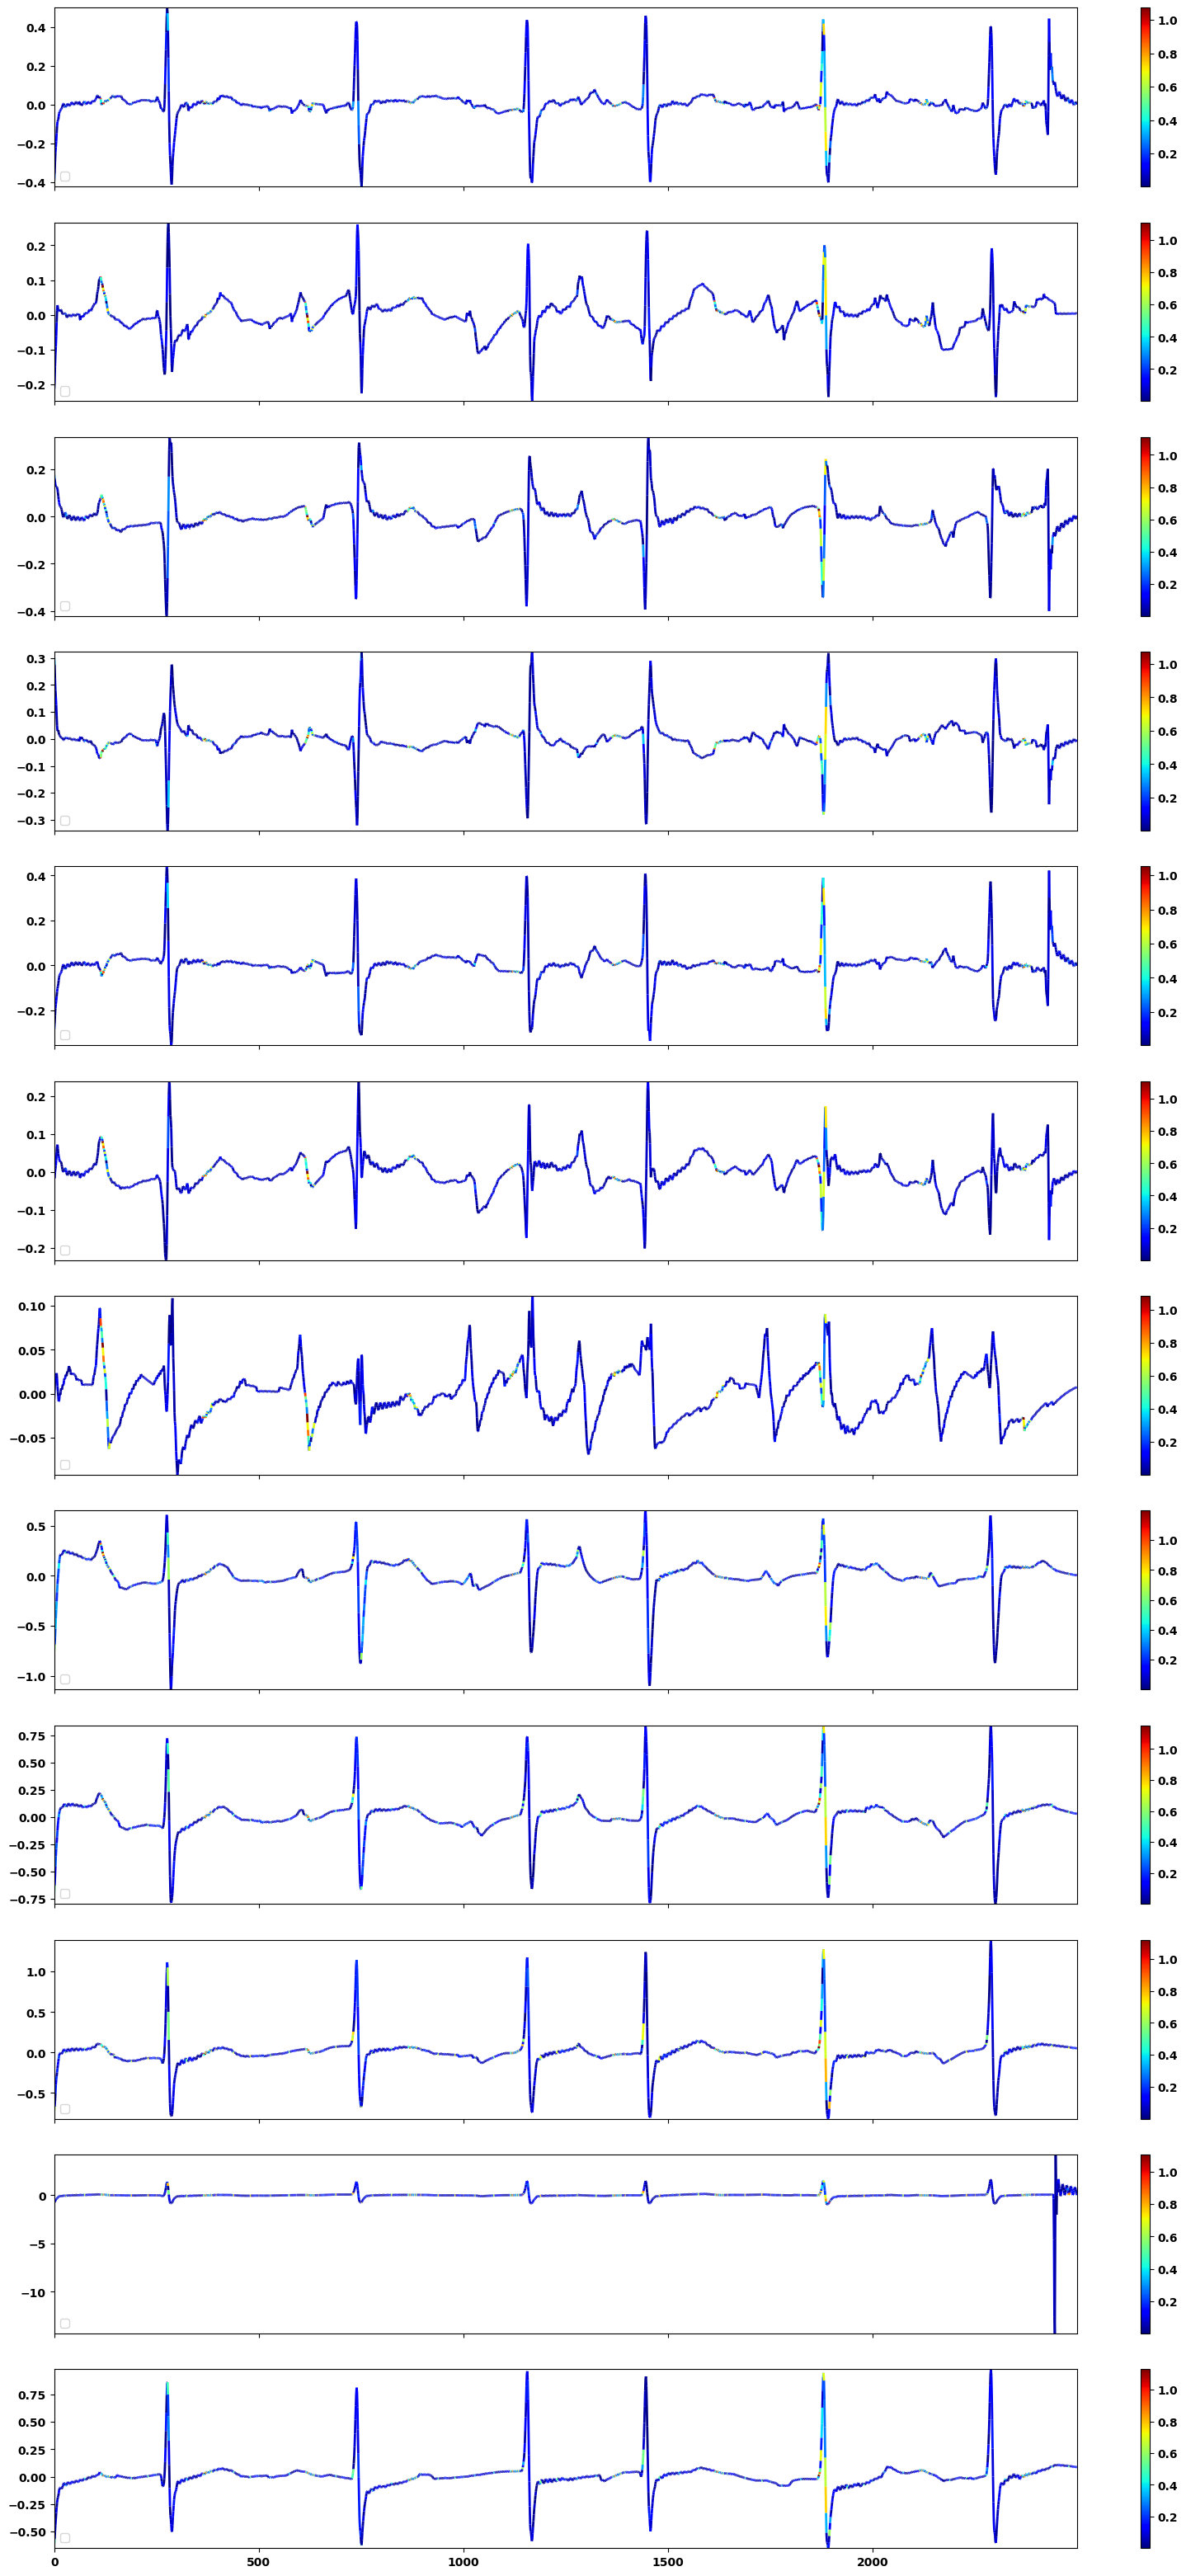

In [ ]:
nchs = 12
fig, axs = plt.subplots(nchs, 1, sharex=True, sharey=False, figsize = (20, 40))
x = np.arange(0, 2500, 1)

for ch in range(nchs):

  y = hr_data[0, ch, :].cpu()
  #print(x.shape, y.shape)

  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  #print(points.shape, segments.shape)

  # Create a continuous norm to map from data points to colors
  norm = plt.Normalize(diff[ch, :].min(), diff[ch, :].max())
  lc = LineCollection(segments, cmap=cm, norm=norm)

  # Set the values used for colormapping
  lc.set_array(diff[ch, :])
  lc.set_linewidth(2)
  if nchs == 1:
    ax = axs
  else:
    ax = axs[ch]

  line = ax.add_collection(lc)
  fig.colorbar(line, ax=ax)
  ax.set_xlim(x.min(), x.max())
  ax.set_ylim(y.min(), y.max())

  #ax.plot(hr_data[0, ch, :].cpu().detach().numpy(), "--g", alpha = 0.5, label = "hr")
  #ax.plot(sr_data[ch, :].cpu().detach().numpy(), "--r", alpha = 0.5, label = "sr")
  ax.legend(loc = "lower left")
plt.show()

In [33]:
def normalize_ecg(ecg, nchs = 12, div = 3):
  ecg_t = []
  for ch in range(nchs):
    print("\r", ch+1, "/", nchs, end = "")
    ecg_t.append(ecg[ch, :]/div)
  ecg_t = np.array(ecg_t)
  return ecg_t

In [25]:
label = "MI"
lr_data = dict_windows_test_lr_n[label][540]

model1d.eval()

for i, block in enumerate(model1d.upsample.decoder):
  if i+1 == 2:
    block.last_tanh = False
  else:
    block.last_tanh = True
for i, block in enumerate(model1d.decoder.decoder):
  if i+1 == 2:
    block.last_tanh = False
  else:
    block.last_tanh = True


pred = model1d([lr_data, None])

nchs = 12

activation = model1d.encoder.get_activations(lr_data, 0)
activation = model1d.encoder.get_activations(activation, 1)
activation = model1d.upsample.get_activations(activation, 0)
activation = model1d.upsample.get_activations(activation, 1)
activation = torch.squeeze(activation, dim = 0)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


 12 / 12

 12 / 12

 12 / 12

 12 / 12

 12 / 12

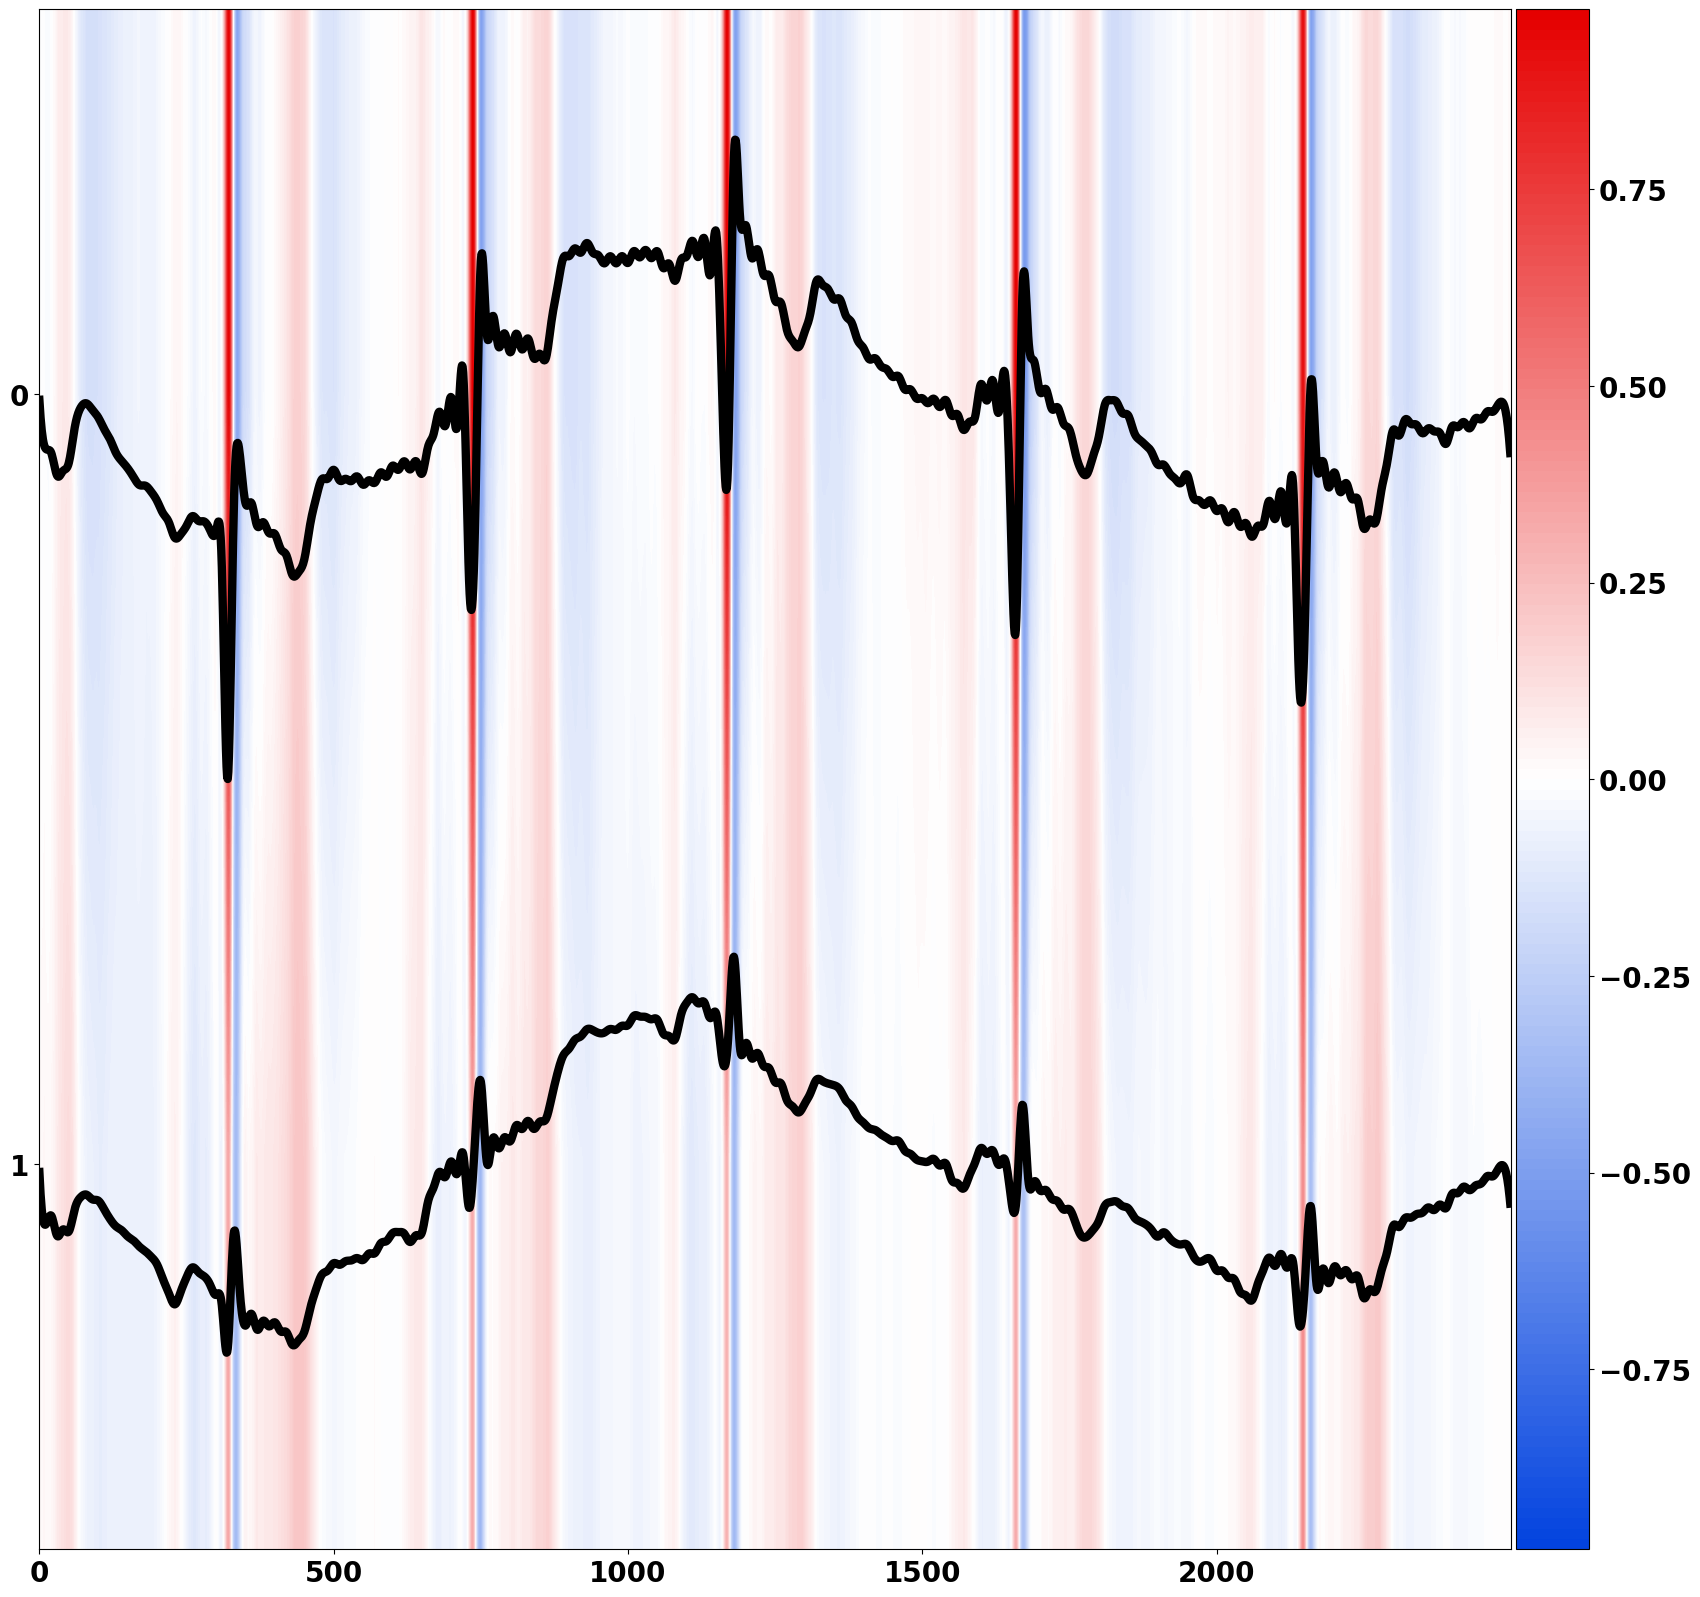

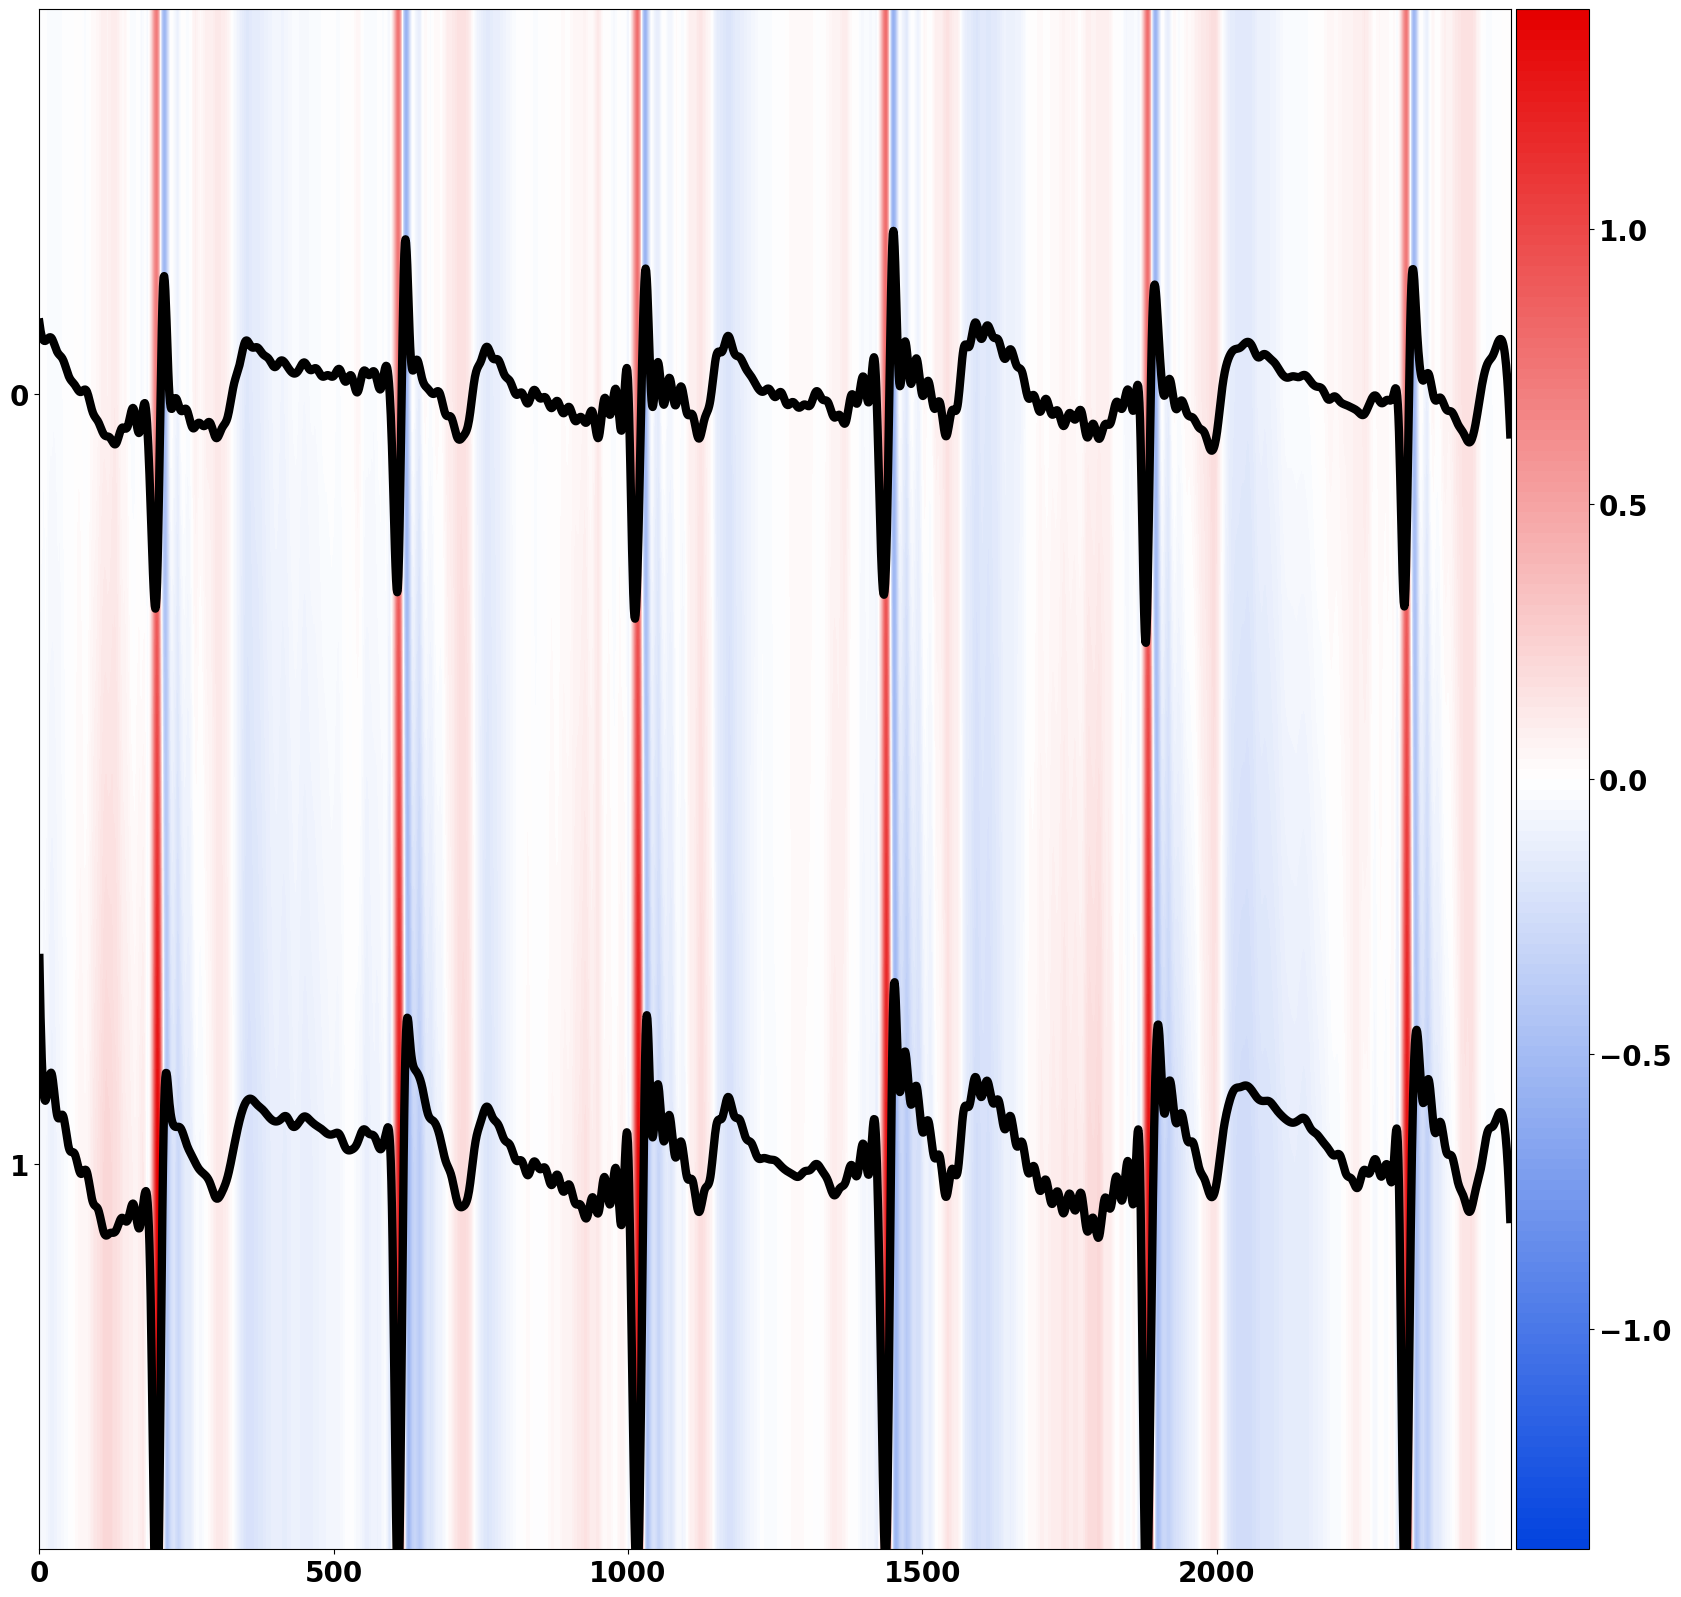

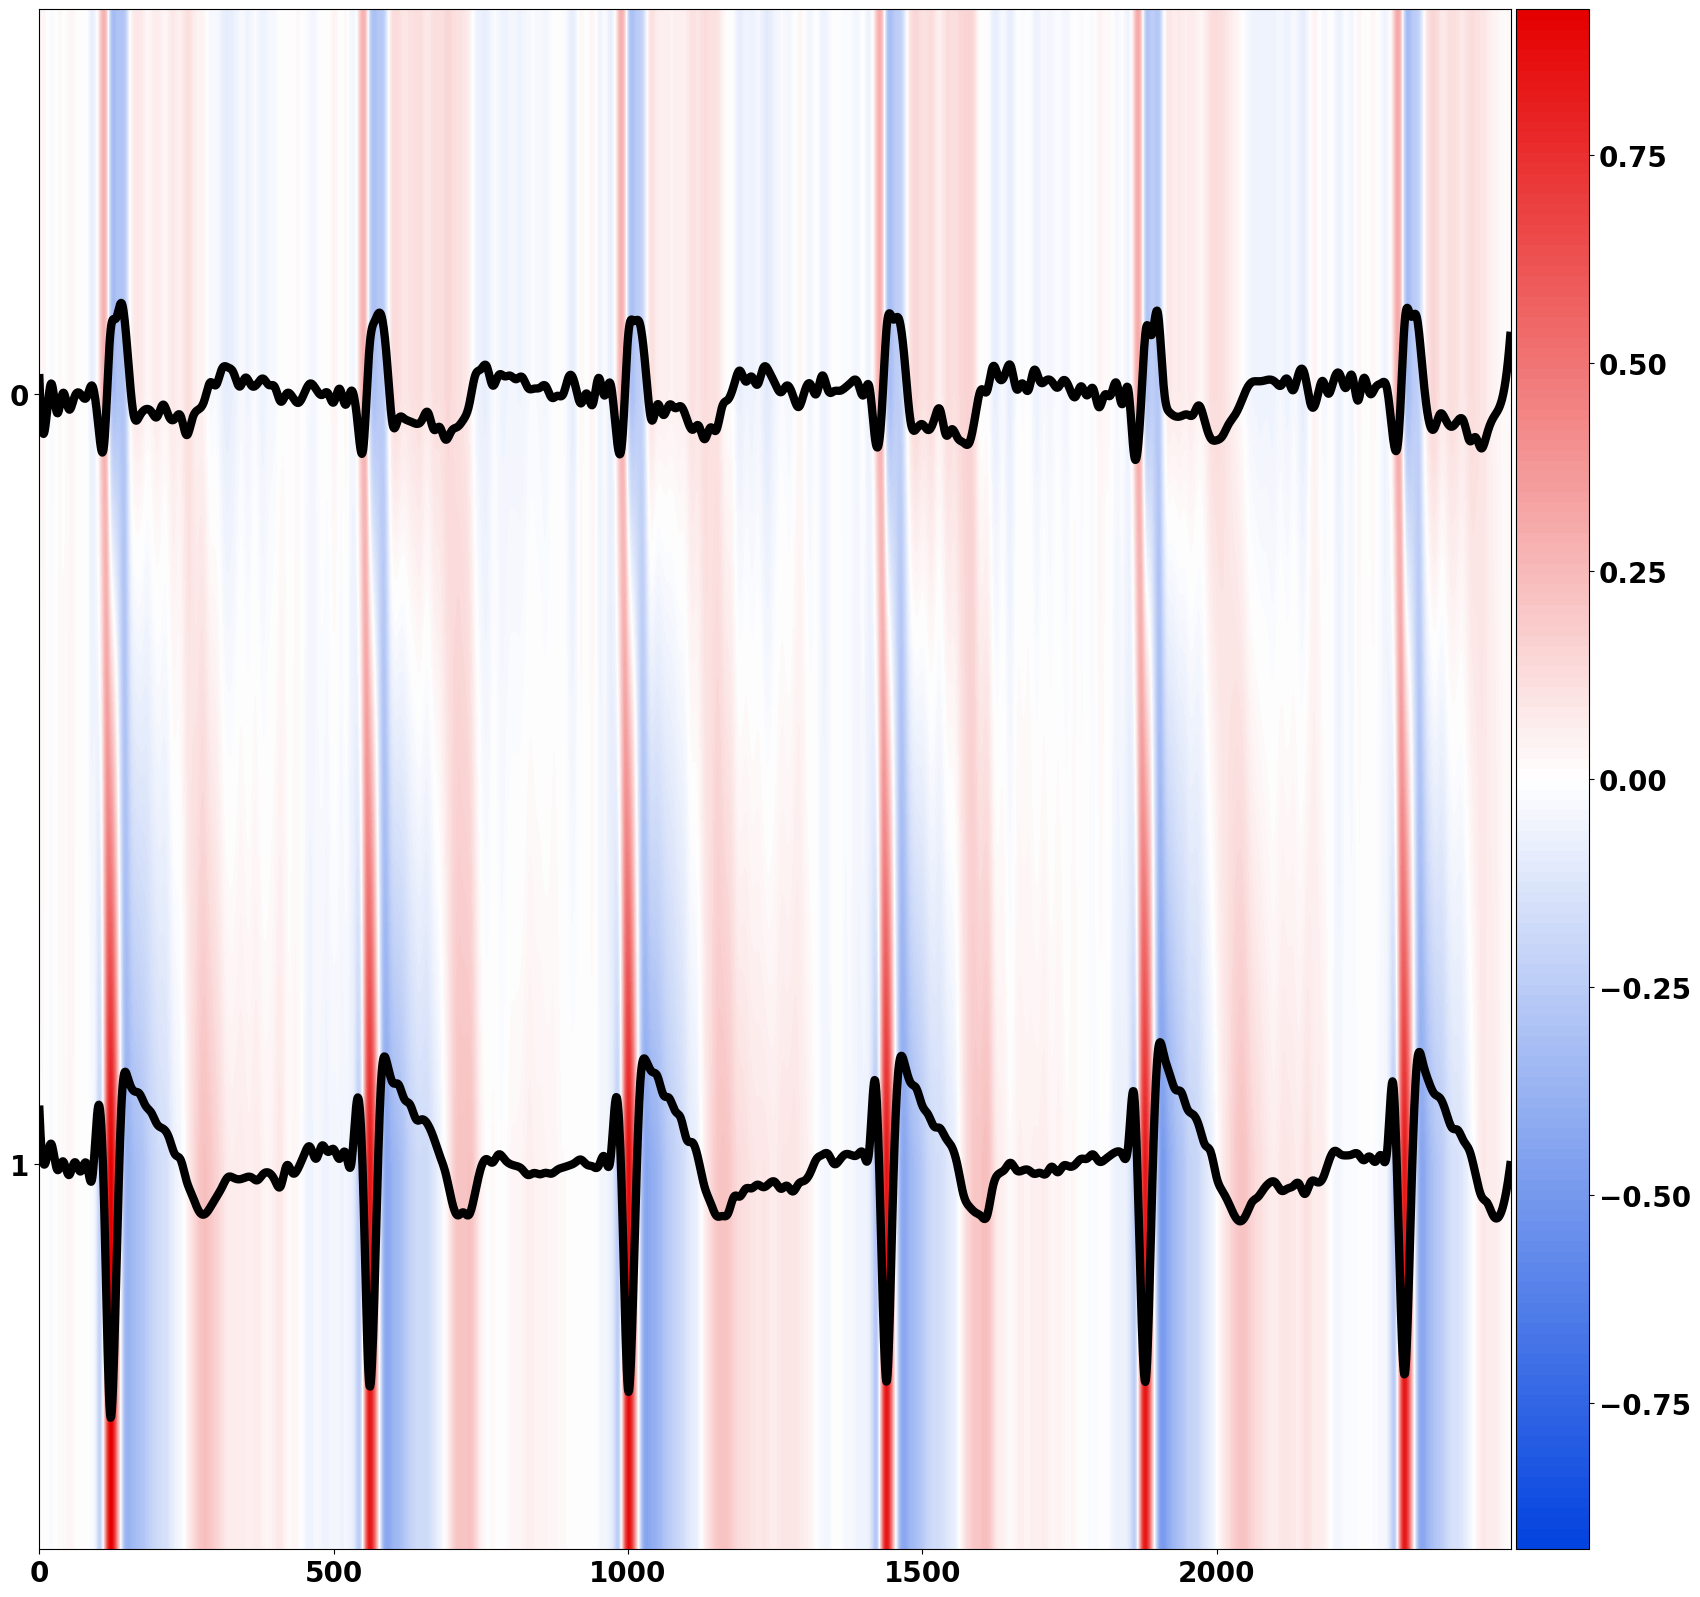

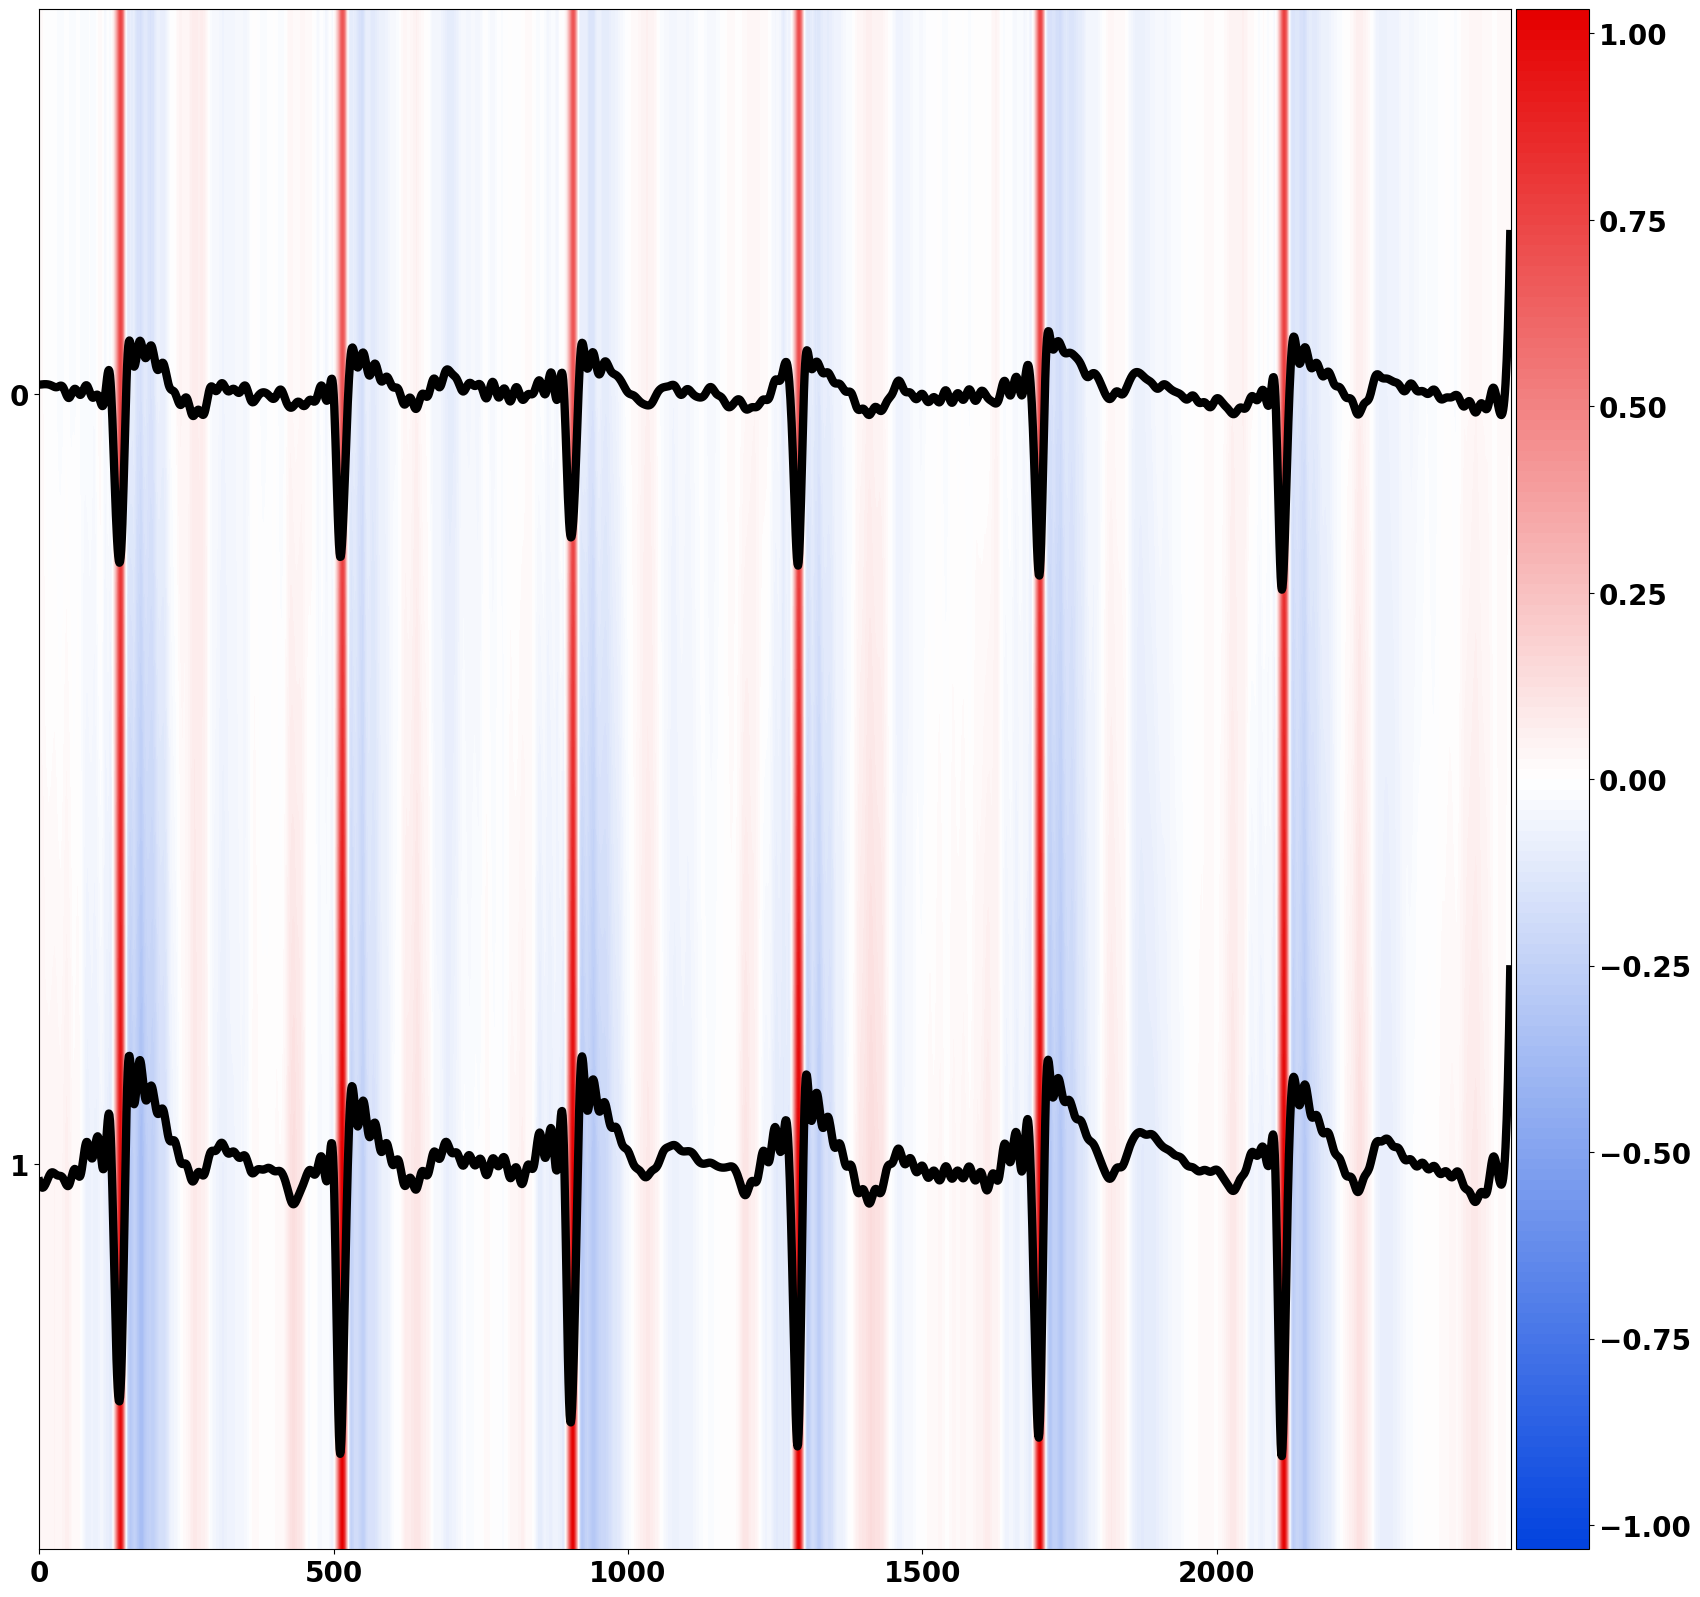

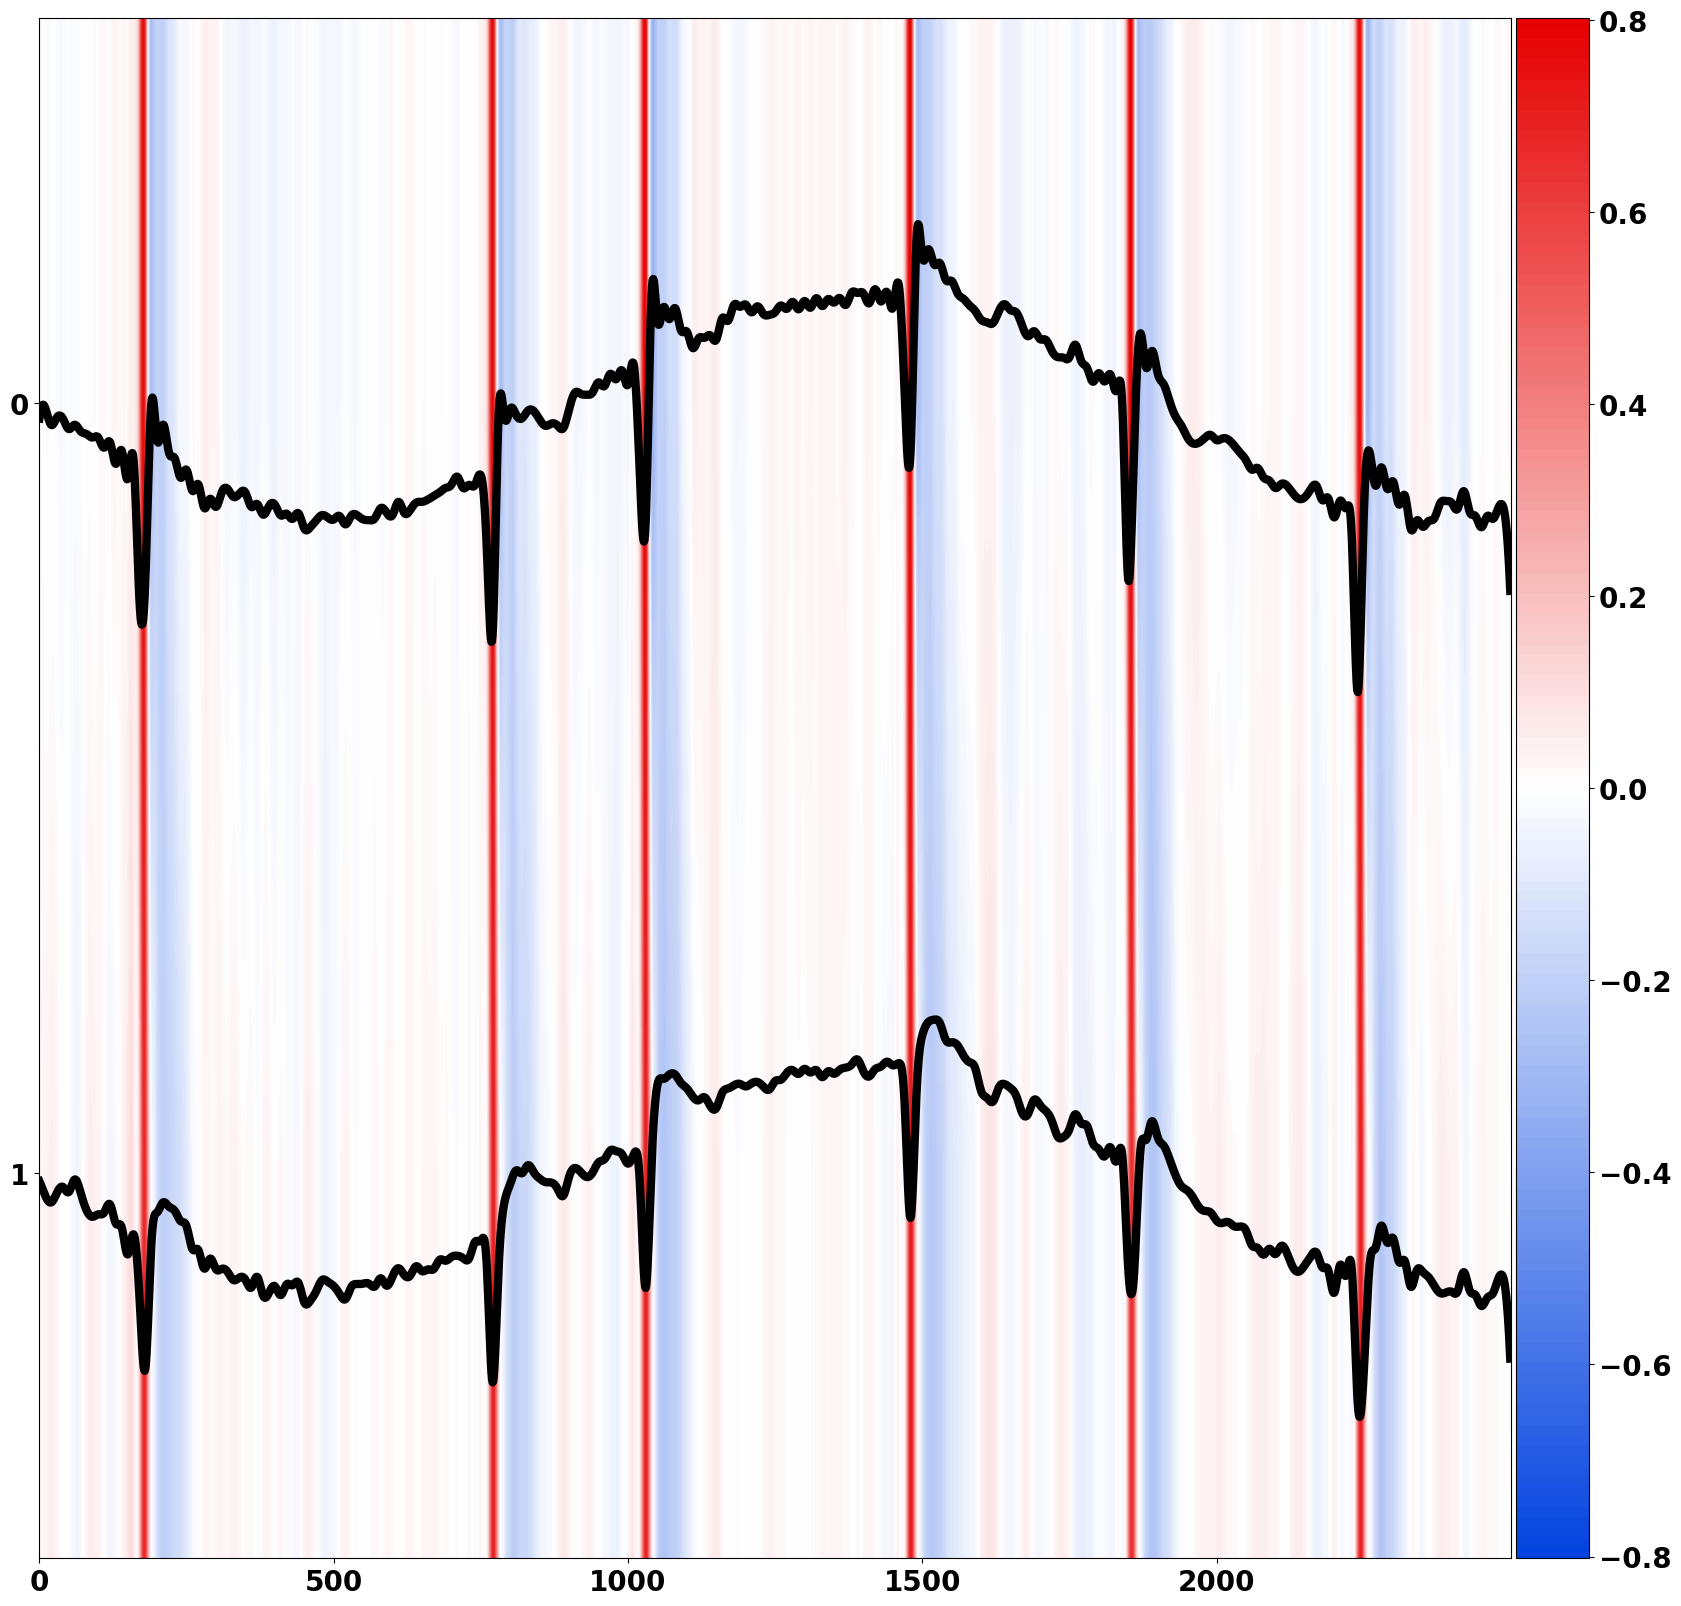

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for label in labels:

  lr_data = dict_windows_test_lr_n[label][50]
  pred = model1d([lr_data, None])

  nchs = 12

  activation = model1d.encoder.get_activations(lr_data, 0)
  activation = model1d.encoder.get_activations(activation, 1)
  activation = model1d.upsample.get_activations(activation, 0)
  activation = model1d.upsample.get_activations(activation, 1)
  activation = torch.squeeze(activation, dim = 0)
  ch = 0
  fig, axs = plt.subplots(figsize = (20, 20))

  lr_data_s = torch.squeeze(lr_data, dim = 0).cpu().detach().numpy()
  lr_data_s = interpolate_sr(lr_data_s)
  lr_data_s = normalize_ecg(lr_data_s)
  offsets = [(i) for i in range(nchs)]
  #for ch in range(nchs):
  #print("\r", ch+1, "/", nchs, end = "")
  off = offsets[ch]

  axs.plot(lr_data_s[ch, :]+offsets[ch], color = "k", linewidth = 6)
  axs.plot(lr_data_s[ch+1, :]+offsets[ch+1], color = "k", linewidth = 6)

  divider = make_axes_locatable(axs)
  cax = divider.append_axes('right', size='5%',  pad=0.05)

  im = axs.imshow(activation[ch:ch+2, :2500].cpu().detach().numpy(), cmap = cm,  norm=matplotlib.colors.CenteredNorm(), interpolation = "bilinear", aspect = "auto")
  axs.set_yticks(np.arange(0, 2, 1))
  fig.colorbar(im, cax = cax, orientation='vertical')

  fig.savefig("activationmap_superresolution_label{}_ch0-1_noised.png".format(label), dpi = 600)

In [36]:
for label in labels:
  idx = 0
  lr_data = dict_windows_test_lr_n[label][idx]
  pred = model1d([lr_data, None])

  nchs = 12

  activation = model1d.encoder.get_activations(lr_data, 0)
  activation = model1d.encoder.get_activations(activation, 1)
  activation = model1d.upsample.get_activations(activation, 0)
  activation = model1d.upsample.get_activations(activation, 1)
  activation = torch.squeeze(activation, dim = 0)
  #plt.rcParams["figure.autolayout"] = True

  fig, axs = plt.subplots(figsize = (20, 10))

  lr_data_s = torch.squeeze(lr_data, dim = 0).cpu().detach().numpy()
  lr_data_s = interpolate_sr(lr_data_s)
  lr_data_s = normalize_ecg(lr_data_s, div = 1.5)
  offsets = [i for i in range(nchs)]
  for ch in range(nchs):
    print("\r", ch+1, "/", nchs, end = "")
    off = offsets[ch]
    axs.plot(lr_data_s[ch, :]+off, color = "k", linewidth = 2)

  divider = make_axes_locatable(axs)
  cax = divider.append_axes('right', size='5%',  pad=0.05)
  im = axs.imshow(activation[:, :2500].cpu().detach().numpy(), cmap = cm, norm=matplotlib.colors.CenteredNorm(), interpolation = "bilinear", aspect = "auto")
  axs.set_yticks(np.arange(0, nchs, 1))
  axs.set_yticklabels(np.arange(1, nchs+1, 1))
  cbar = fig.colorbar(im, cax = cax, orientation='vertical')

  plt.legend(fontsize="26")
  axs.xaxis.set_tick_params(labelsize=32)
  axs.yaxis.set_tick_params(labelsize=32)

  for t in cbar.ax.get_yticklabels():
     t.set_fontsize(36)

  fig.show()
  fig.savefig("activationmap_superresolution_label{}.png".format(label), dpi = 600)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
for label in labels:
  idx = 0
  lr_data = dict_windows_test_lr[label][idx]
  pred = model1d([lr_data, None])

  nchs = 12

  activation = model1d.encoder.get_activations(lr_data, 0)
  activation = model1d.encoder.get_activations(activation, 1)
  activation = model1d.upsample.get_activations(activation, 0)
  activation = model1d.upsample.get_activations(activation, 1)
  activation = torch.squeeze(activation, dim = 0)
  #plt.rcParams["figure.autolayout"] = True

  fig, axs = plt.subplots(figsize = (20, 10))

  lr_data_s = torch.squeeze(lr_data, dim = 0).cpu().detach().numpy()
  lr_data_s = interpolate_sr(lr_data_s)
  lr_data_s = normalize_ecg(lr_data_s, div = 1)
  offsets = [i for i in range(nchs)]
  for ch in range(nchs):
    print("\r", ch+1, "/", nchs, end = "")
    off = offsets[ch]
    axs.plot(lr_data_s[ch, :]+off, color = "k")

  divider = make_axes_locatable(axs)
  cax = divider.append_axes('right', size='5%',  pad=0.05)
  im = axs.imshow(activation[:, :2500].cpu().detach().numpy(), cmap = cm, norm=matplotlib.colors.CenteredNorm(), interpolation = "bilinear", aspect = "auto")
  axs.set_yticks(np.arange(0, nchs, 1))
  axs.set_yticklabels(np.arange(1, nchs+1, 1))
  cbar = fig.colorbar(im, cax = cax, orientation='vertical')

  plt.legend(fontsize="26")
  axs.xaxis.set_tick_params(labelsize=32)
  axs.yaxis.set_tick_params(labelsize=32)

  for t in cbar.ax.get_yticklabels():
     t.set_fontsize(36)
  fig.show()
  fig.savefig("activationmap_superresolution_label{}_nonoise.png".format(label), dpi = 600)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# Function to generate saliency map
def saliency(input, model, div = 1):

    print(input.is_leaf)
    device = "cuda:0"
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.to(device).eval()
    #input.unsqueeze_(0)

    input.requires_grad = True

    #forward pass to calculate predictions

    preds = model([input, None, None, None])[0]
    print(preds.shape)

    scores, indices = torch.max(preds, 1)
    score = scores[0]
    print(score)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()

    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad), dim=0)
    print(slc.shape)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #plot image and its saleincy map
    fig, axs = plt.subplots(figsize=(20, 10))
    nchs = 12

    lr_data_s = torch.squeeze(input, dim = 0).cpu().detach().numpy()
    #lr_data_s = interpolate_sr(lr_data_s)
    lr_data_s = normalize_ecg(lr_data_s, div = div)

    offsets = [(i) for i in range(nchs)]
    for ch in range(nchs):
      print("\r", ch+1, "/", nchs, end = "")
      off = offsets[ch]
      axs.plot(lr_data_s[ch, :]+off, color = "k", linewidth = 2)

    axs.set_yticks(np.arange(0, nchs, 1))

    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='5%',  pad=0.05)

    im = axs.imshow(slc.cpu().detach().numpy(), cmap=cm, aspect = 'auto',norm=matplotlib.colors.CenteredNorm(),  interpolation="bilinear")
    fig.colorbar(im, cax = cax, orientation='vertical')
    plt.xticks([])
    return fig

True
torch.Size([12, 250])
tensor(0.4121, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([12, 250])
 12 / 12

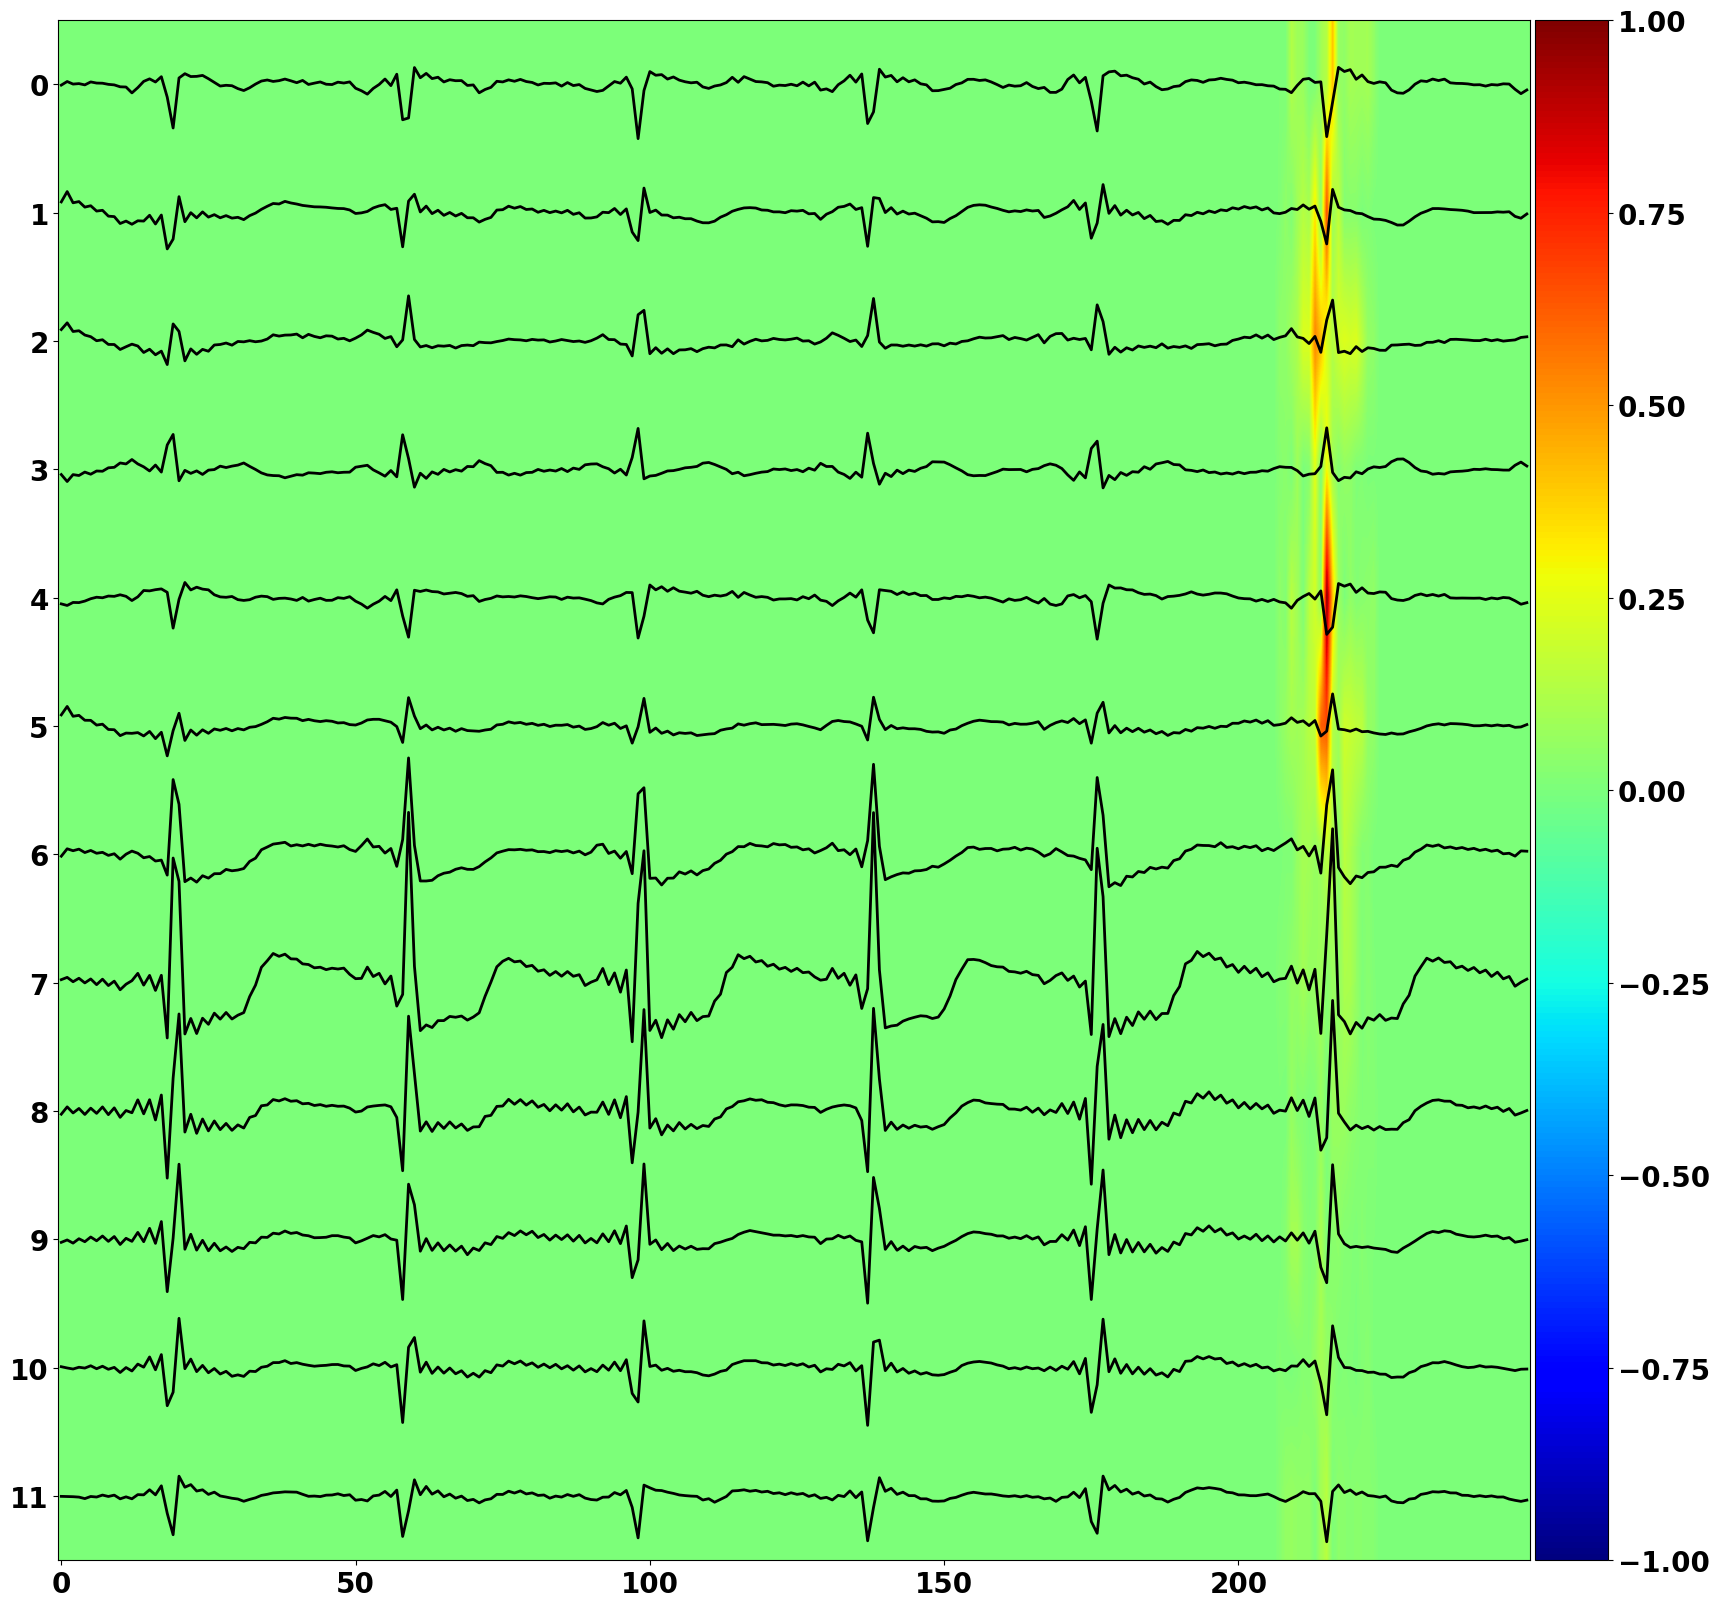

In [ ]:
# Generate saliency map
fig = saliency(lr_data, model1d)

True
torch.Size([12, 250])
tensor(1.1877, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([12, 250])
 12 / 12

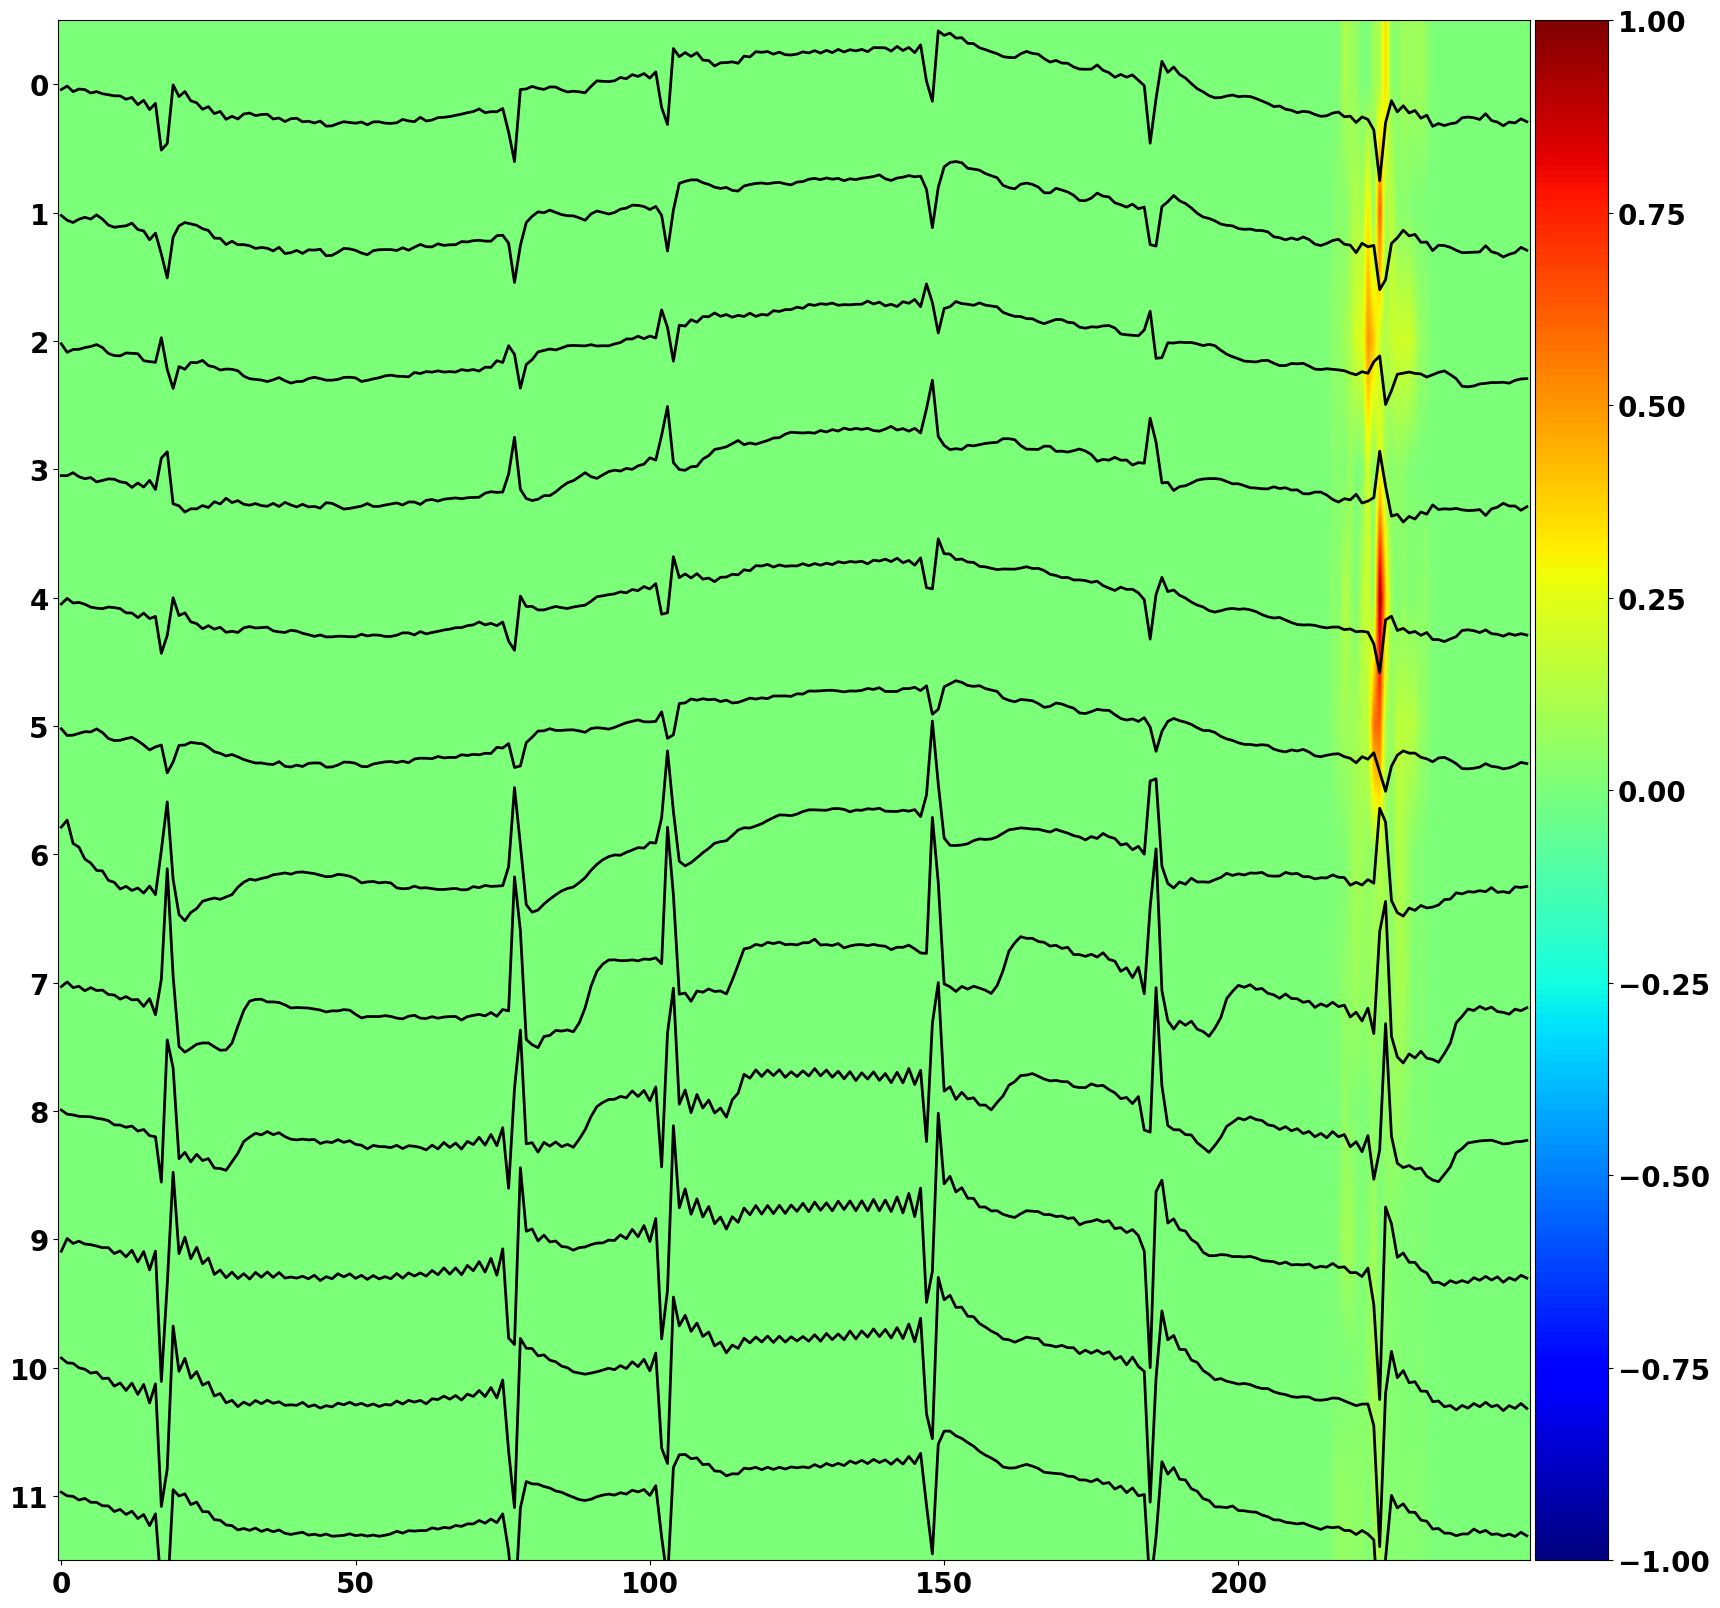

In [ ]:
# Generate saliency map
idx = 50
lr_data = dict_windows_test_lr_n[label][idx]
fig = saliency(lr_data, model1d, div = 1.5)

In [ ]:
for label in labels:

  idx = 0
  lr_data = dict_windows_test_lr_n[label][idx]
  pred = model1d([lr_data, None])
  fig = saliency(lr_data, model1d)
  fig.show()
  fig.savefig("saliencymap_superresolution_label{}.png".format(label), dpi = 600)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for label in labels:

  idx = 0
  lr_data = dict_windows_test_lr[label][idx]
  pred = model1d([lr_data, None])
  fig = saliency(lr_data, model1d)
  fig.show()
  fig.savefig("saliencymap_superresolution_label{}_NONOISE.png".format(label), dpi = 600)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
import neurokit2 as nk

In [28]:
import random

def add_rsp(signal):

    nchs = 12
    duration = 5
    fs = 50

    while True:
        rr_all = np.arange(10, 20, 2)
        rr = random.choice(rr_all)
        #print(rr)
        resp = nk.rsp_simulate(length=fs*duration, sampling_rate = fs, respiratory_rate=rr, method="breathmetrics")

        temp = [torch.from_numpy(resp) for i in range(nchs)]
        resp = torch.from_numpy(np.array(temp))

        if signal.shape == resp.shape:
            break
    noisy_signal = signal.cpu() + resp

    return noisy_signal

In [29]:
def add_emg(signal):

    nchs = 12
    duration = 5
    fs = 50

    bn = random.choice(np.arange(1, 2))
    emg = nk.emg_simulate(length=fs*duration, sampling_rate = fs, burst_number=bn, burst_duration=1)

    temp = [torch.from_numpy(emg) for i in range(nchs)]
    emg = torch.from_numpy(np.array(temp))
    noisy_signal = signal.cpu() + emg
    return noisy_signal

In [30]:
def add_eda(signal):

    nchs = 12
    duration = 5
    fs = 50

    edan = random.choice(np.arange(1, 2))
    eda = nk.eda_simulate(duration = 5, length=fs*duration, sampling_rate = fs, scr_number=edan, drift=-0.5)

    temp = [torch.from_numpy(eda) for i in range(nchs)]
    eda = torch.from_numpy(np.array(temp))
    noisy_signal = signal.cpu() + eda
    return noisy_signal

True
torch.Size([12, 250])
tensor(0.9570, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([12, 250])
 12 / 12True
torch.Size([12, 250])
tensor(0.6793, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([12, 250])
 12 / 12True
torch.Size([12, 250])
tensor(0.6597, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([12, 250])
 12 / 12True
torch.Size([12, 250])
tensor(0.9814, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([12, 250])
 12 / 12

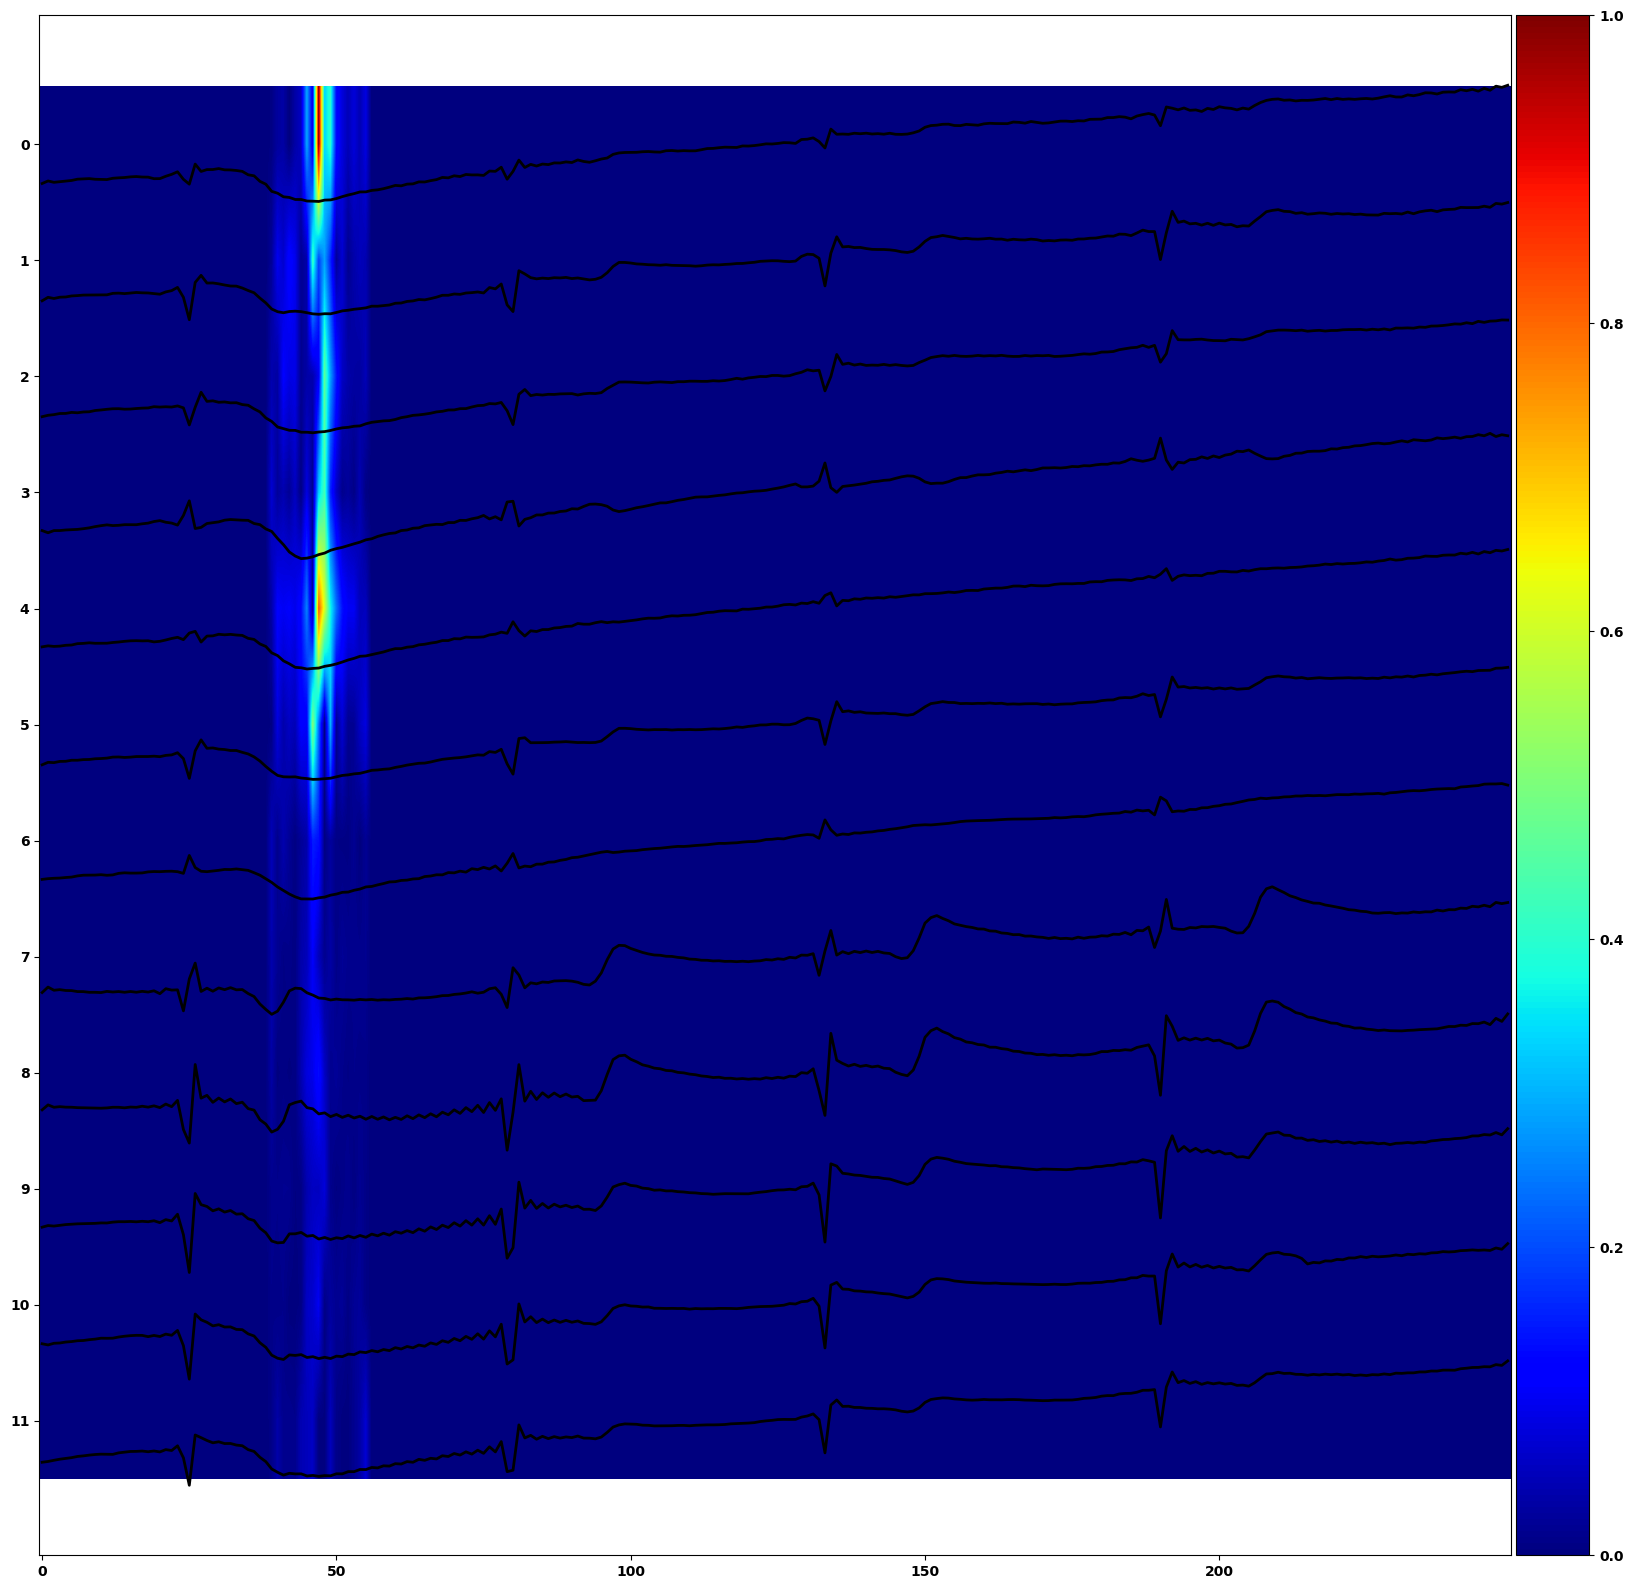

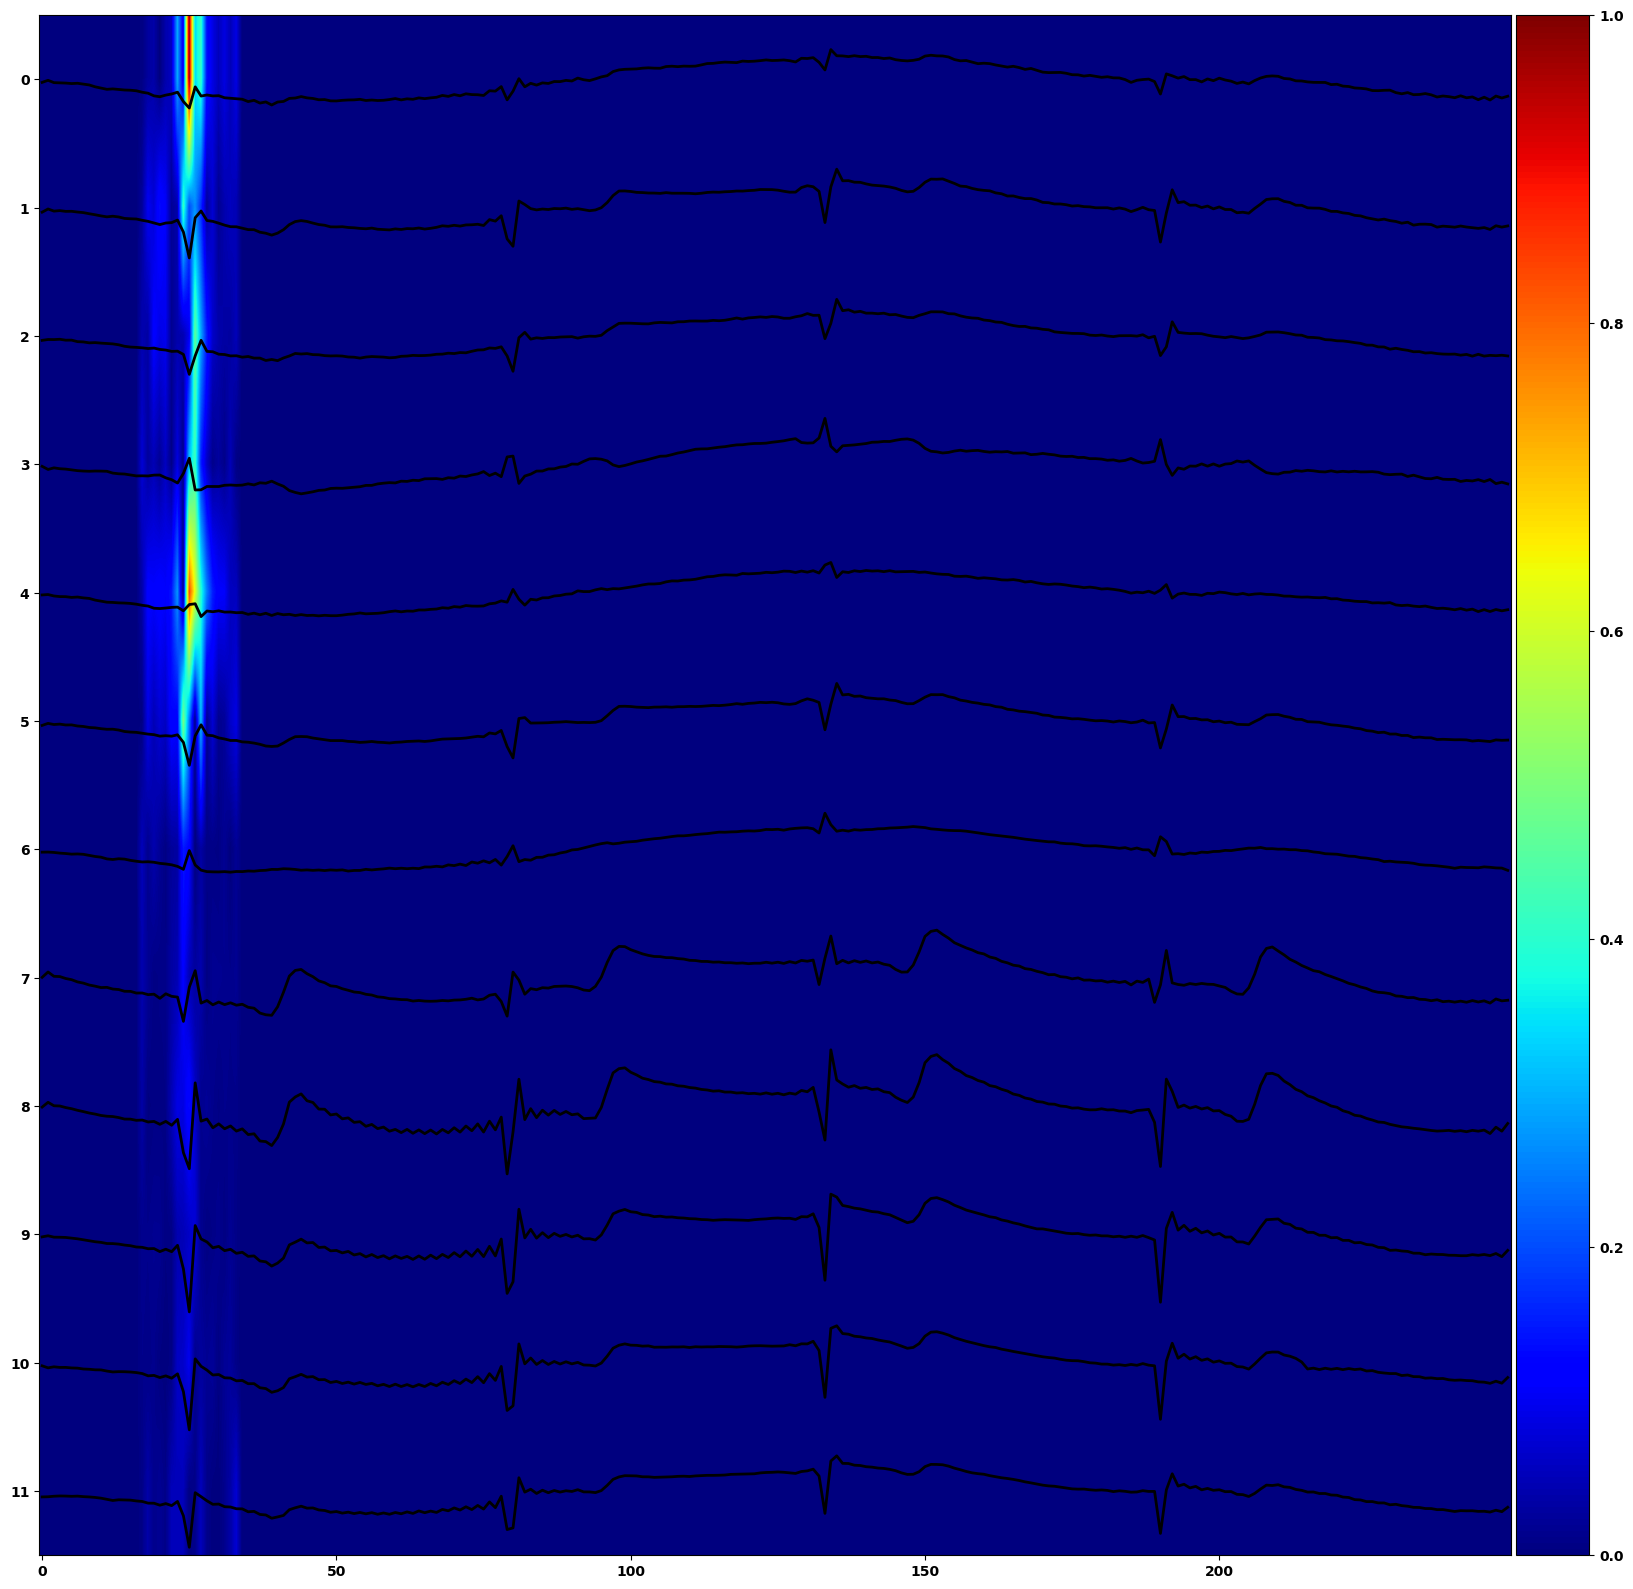

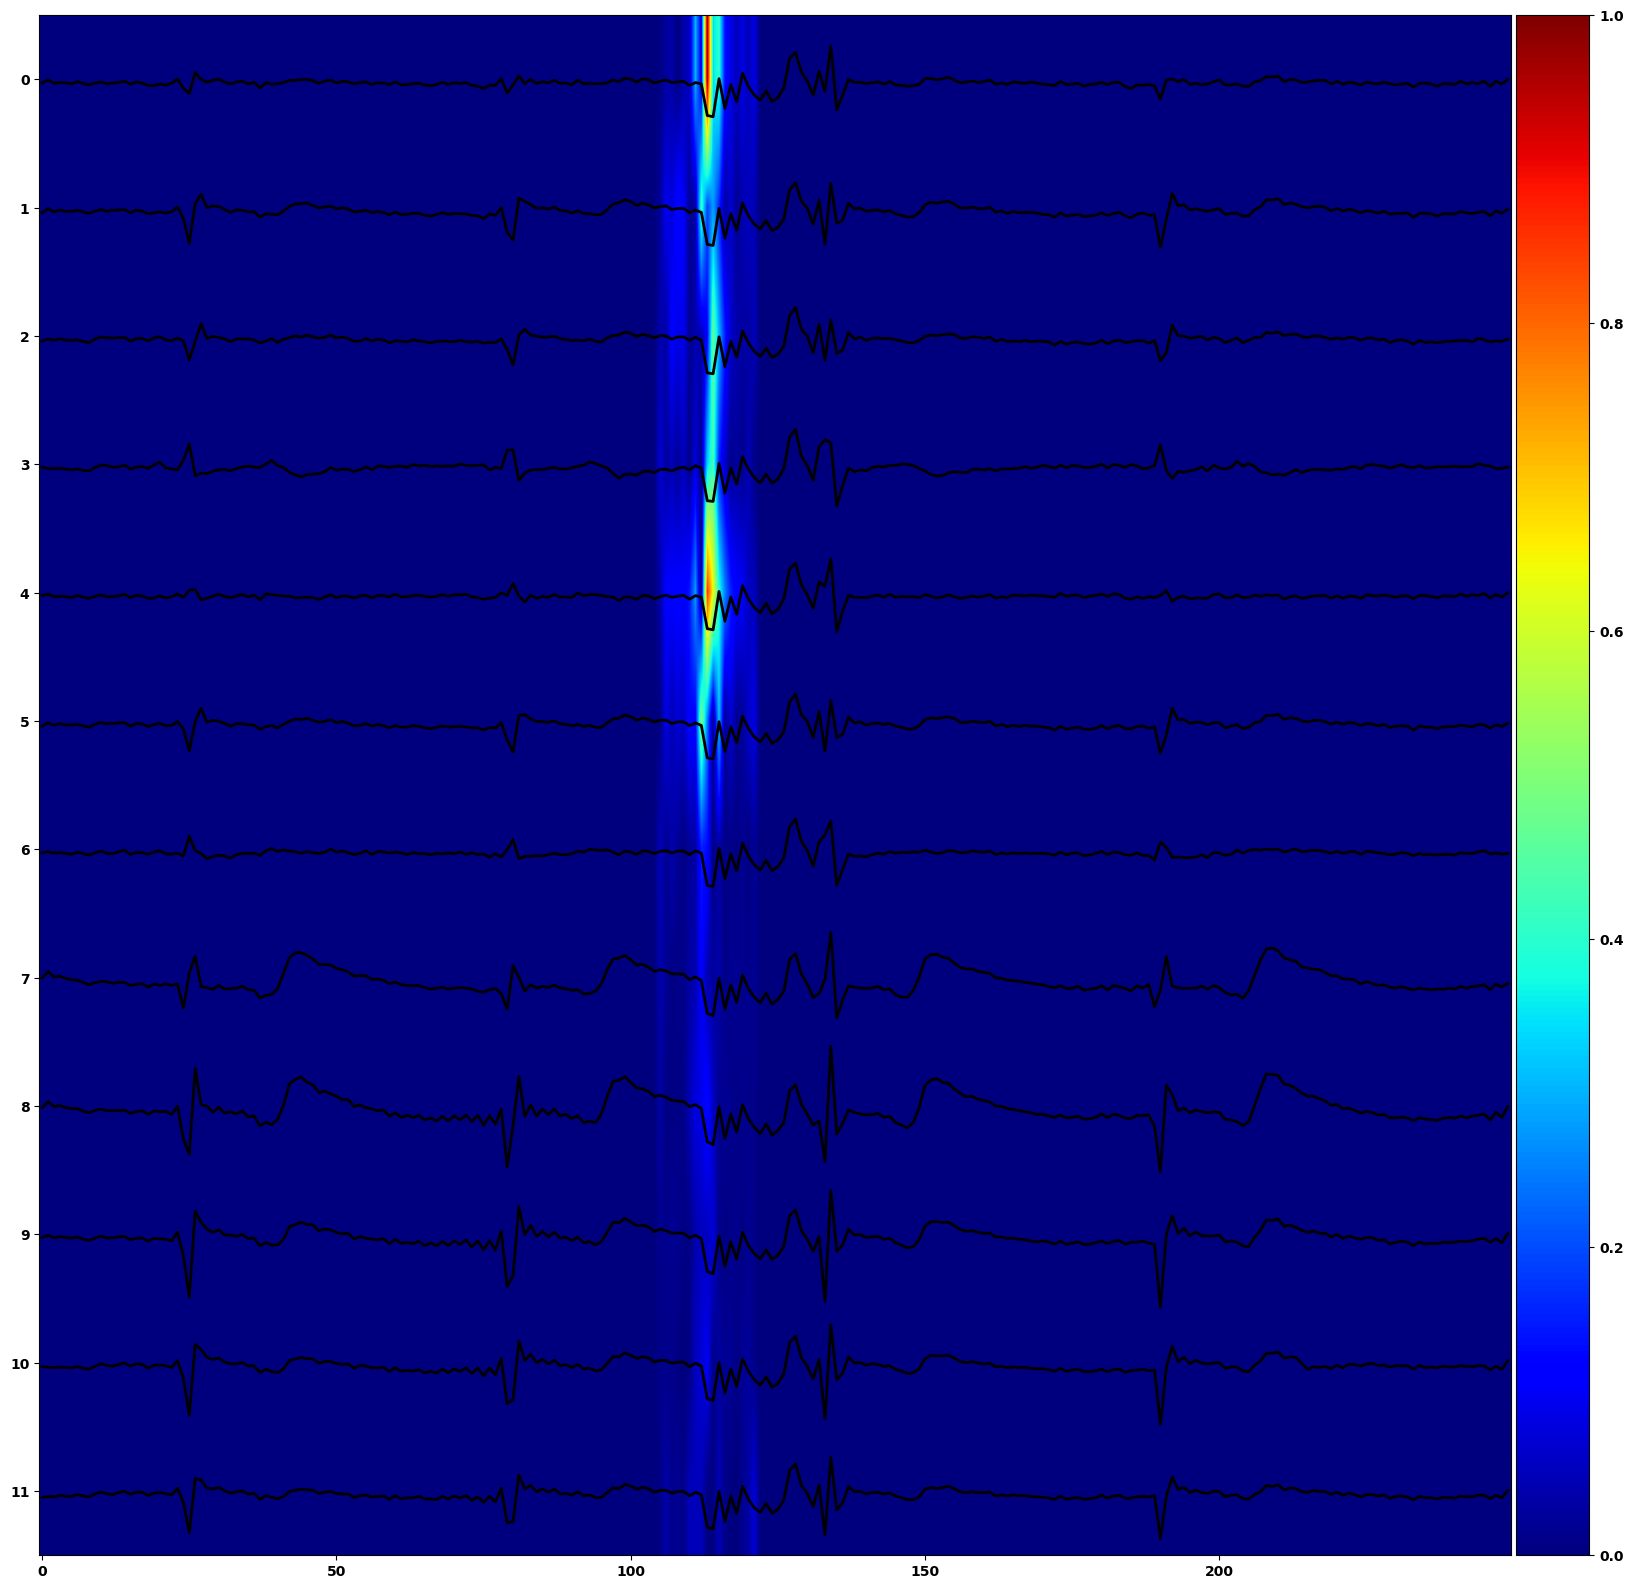

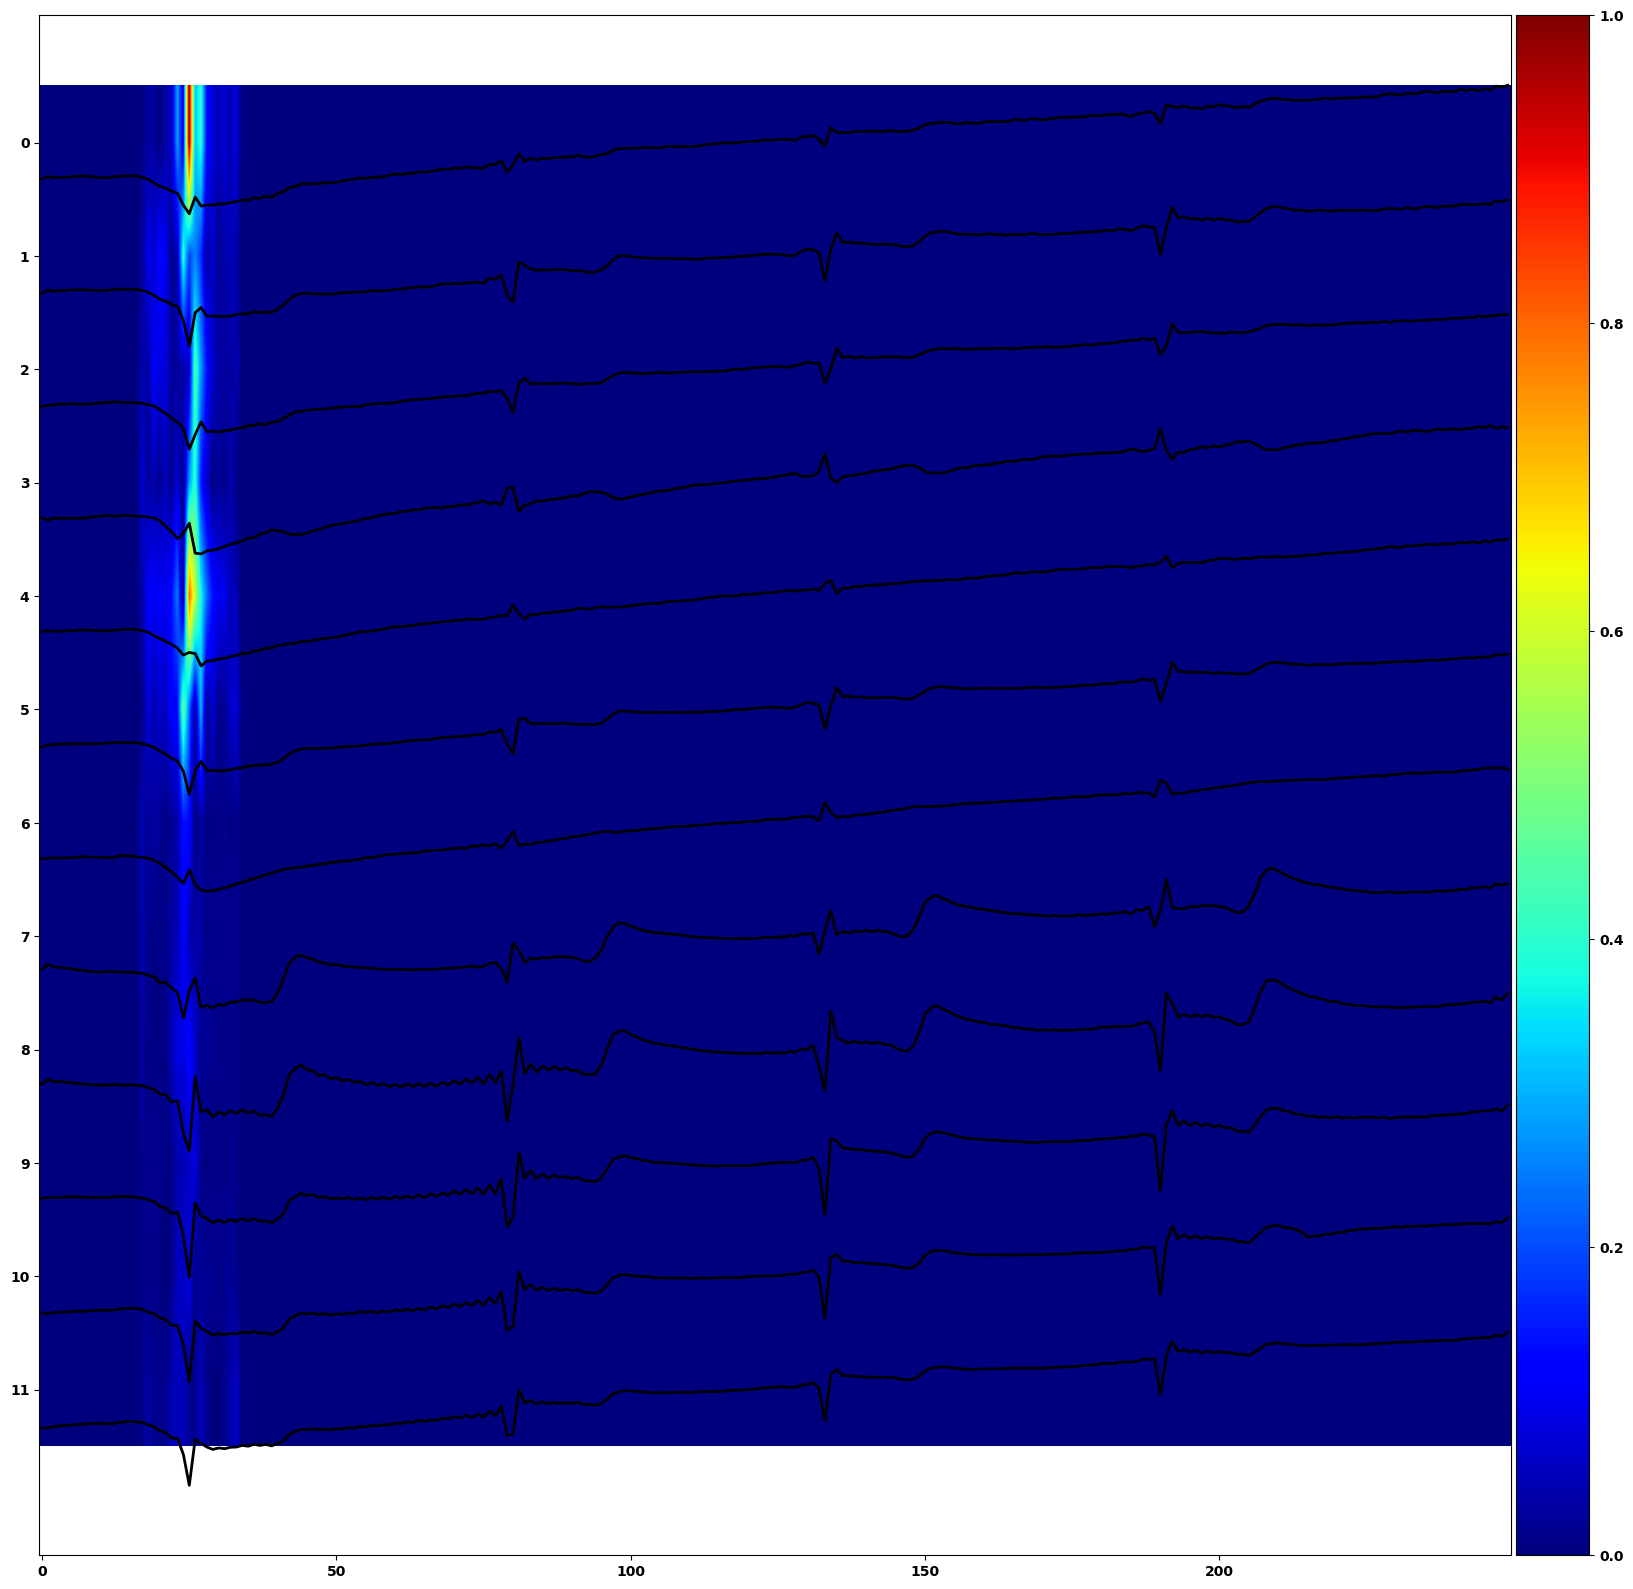

In [ ]:
noise_functions = {
    "Respiration Noise": add_rsp,
    "EMG artifact": add_emg,
    "EDA artifact": add_eda
}

label = "NORM"
idx = 10
signal = dict_windows_test_lr[label][idx, 0, :, :]
fig = saliency(signal, model1d)
fig.savefig("saliencymap_superresolution_label{}_idx{}_noiseNO.png".format(label, idx), dpi = 600)
for noise_type, noise_function in noise_functions.items():

  signal_noised = noise_function(signal)
  signal_noised = torch.unsqueeze(signal_noised, dim =0).to(device).float()
  fig = saliency(signal_noised, model1d)
  fig.show()
  plt.legend(fontsize="26")
  plt.xticks(fontsize=26)
  plt.yticks(fontsize=26)
  fig.savefig("saliencymap_superresolution_label{}_idx{}_noise{}.png".format(label, idx, noise_type), dpi = 600)

True
torch.Size([12, 250])
tensor(0.3588, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([12, 250])
 12 / 12

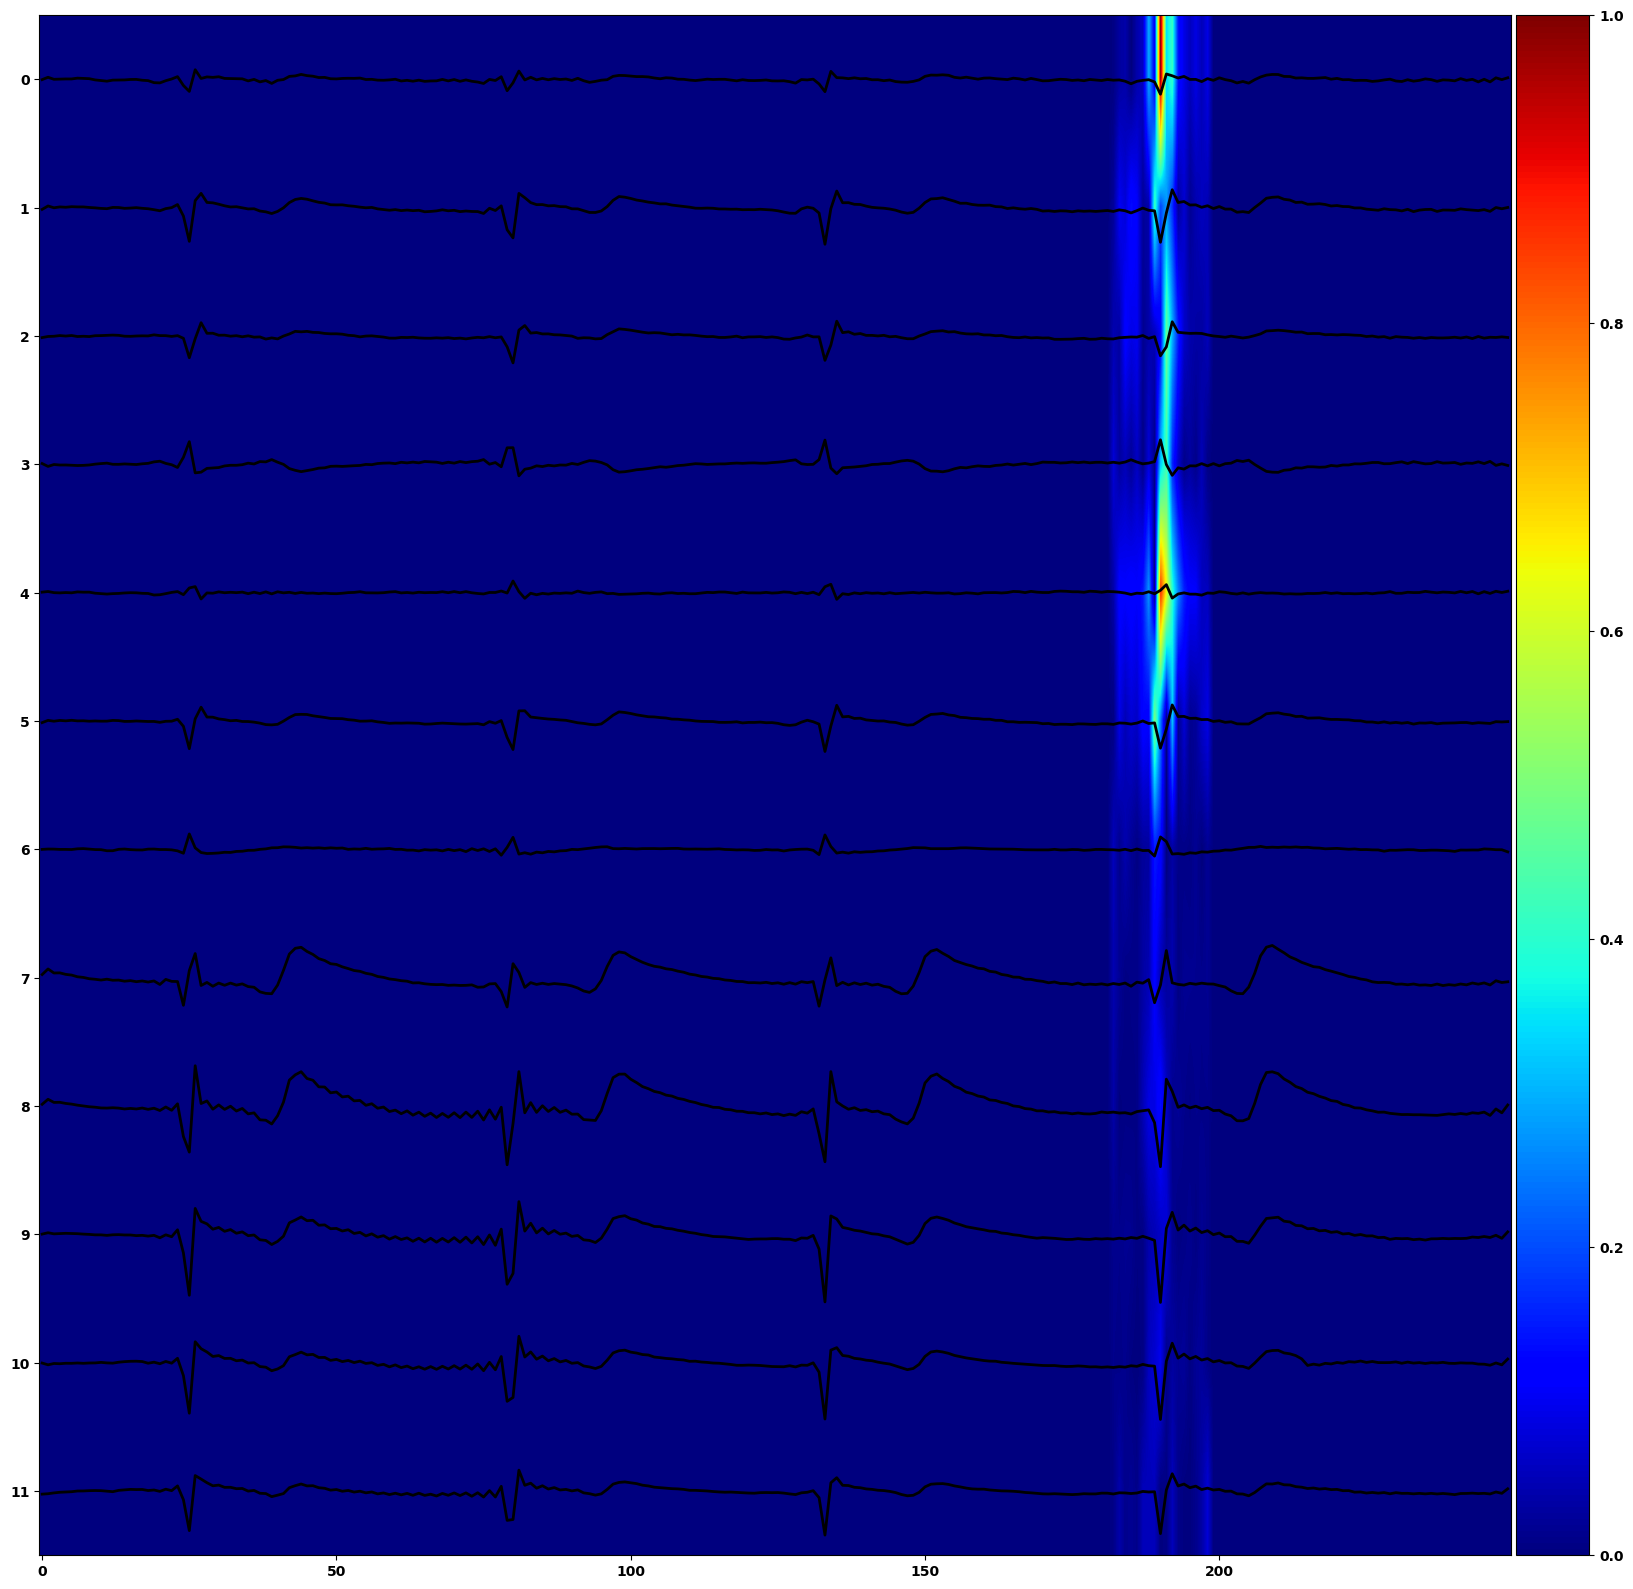

In [ ]:
fig = saliency(signal, model1d)
fig.savefig("saliencymap_superresolution_label{}_idx{}_noiseNO.png".format(label, idx), dpi = 600)

In [ ]:
for noise_type, noise_function in noise_functions.items():

  signal = signal.squeeze(dim = 0)
  signal_noised = noise_function(signal)
  signal_noised = torch.unsqueeze(signal_noised, dim = 0).to(device).float()
  pred = model1d([signal_noised, None])

  nchs = 12

  activation = model1d.encoder.get_activations(signal_noised, 0)
  activation = model1d.encoder.get_activations(activation, 1)
  activation = model1d.upsample.get_activations(activation, 0)
  activation = model1d.upsample.get_activations(activation, 1)
  activation = torch.squeeze(activation, dim = 0)
  #plt.rcParams["figure.autolayout"] = True

  fig, axs = plt.subplots(figsize = (20, 20))

  divider = make_axes_locatable(axs)
  cax = divider.append_axes('right', size='5%',  pad=0.05)
  im = axs.imshow(activation[:, :2500].cpu().detach().numpy(), cmap = cm, norm=matplotlib.colors.CenteredNorm(), interpolation = "bilinear", aspect = "auto")
  axs.set_yticks(np.arange(0, nchs, 1))
  fig.colorbar(im, cax = cax, orientation='vertical')

  lr_data_s = torch.squeeze(signal_noised, dim = 0).cpu().detach().numpy()
  lr_data_s = interpolate_sr(lr_data_s)
  lr_data_s = normalize_ecg(lr_data_s, div = 1.5)
  offsets = [i for i in range(nchs)]
  for ch in range(nchs):
    print("\r", ch+1, "/", nchs, end = "")
    off = offsets[ch]
    axs.plot(lr_data_s[ch, :]+off, color = "k")

  fig.show()
  fig.savefig("activationmap_superresolution_label{}_idx{}_noise{}.png".format(label, idx, noise_type), dpi = 600)


Output hidden; open in https://colab.research.google.com to view.

 12 / 12

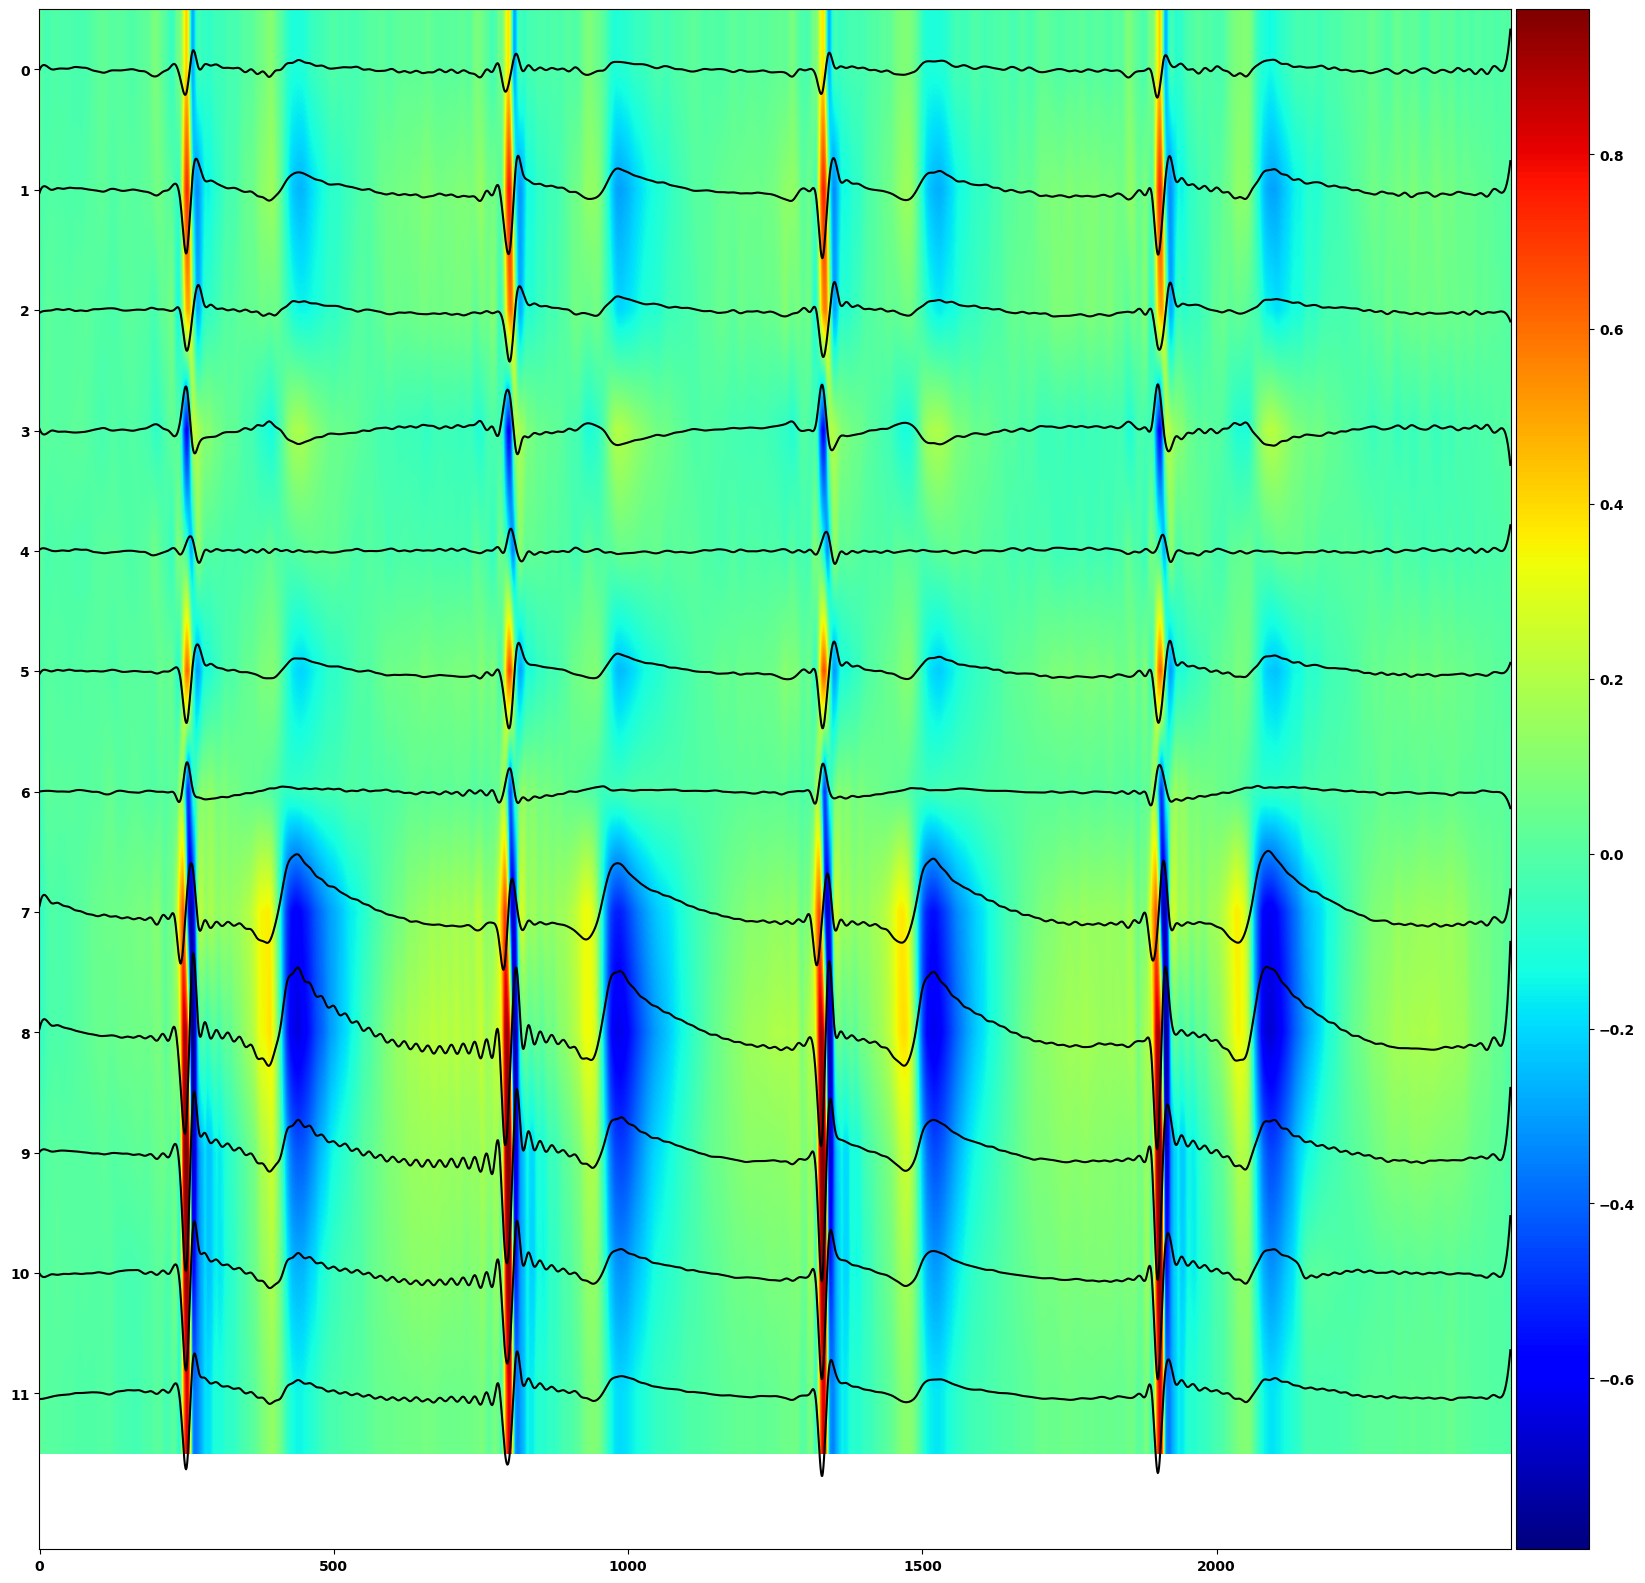

In [ ]:
label = "NORM"
idx = 10
signal = dict_windows_test_lr[label][idx, 0, :, :]

pred = model1d([signal, None])
nchs = 12

activation = model1d.encoder.get_activations(signal, 0)
activation = model1d.encoder.get_activations(activation, 1)
activation = model1d.upsample.get_activations(activation, 0)
activation = model1d.upsample.get_activations(activation, 1)
activation = torch.squeeze(activation, dim = 0)
#plt.rcParams["figure.autolayout"] = True

fig, axs = plt.subplots(figsize = (20, 20))

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%',  pad=0.05)
im = axs.imshow(activation[:, :2500].cpu().detach().numpy(), cmap = cm, norm=matplotlib.colors.CenteredNorm(), interpolation = "bilinear", aspect = "auto")
axs.set_yticks(np.arange(0, nchs, 1))
fig.colorbar(im, cax = cax, orientation='vertical')

signal = signal.unsqueeze(0)
lr_data_s = torch.squeeze(signal, dim = 0).cpu().detach().numpy()
lr_data_s = interpolate_sr(lr_data_s)
lr_data_s = normalize_ecg(lr_data_s, div = 1.5)
offsets = [i for i in range(nchs)]
for ch in range(nchs):
  print("\r", ch+1, "/", nchs, end = "")
  off = offsets[ch]
  axs.plot(lr_data_s[ch, :]+off, color = "k")

fig.show()
fig.savefig("activationmap_superresolution_label{}_idx{}_noiseNO.png".format(label, idx), dpi = 600)